# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/2322/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

### First steps

My computer couldn´t stand for this kind of project. So, I migrated the project to Google Colab.

Source of code for this step: **Google Colab Documentation**


In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#from pathlib import Path
#patmy = Path('/content/gdrive/MyDrive/GoogleColab/DataScientistStudies3')

See if everything is in the directory

In [2]:
%ls /content/gdrive/MyDrive/GoogleColab/DataScientistStudies3

backups/                 LICENSE                         tests.py
data/                    movie_matrix                    top_10.p
graphs/                  original_notebooks/             top_20.p
helper.py                project_tests.py                top_5.p
L2L3StudiesNotese.ipynb  README.md                       udacourse3.py
L5L6StudiesNotesn.ipynb  Recommendations_with_IBM.ipynb  user_item_matrix.p
L7StudiesNotesc.ipynb    svd_tests.py                    user_matrix


Moving from Google Drive to the virtual machine

In [3]:
#copying libraries into google colab virtual machine
!cp /content/gdrive/MyDrive/GoogleColab/DataScientistStudies3/project_tests.py .
!cp /content/gdrive/MyDrive/GoogleColab/DataScientistStudies3/udacourse3.py .

#aditional picle files for validation
!cp /content/gdrive/MyDrive/GoogleColab/DataScientistStudies3/top_5.p .
!cp /content/gdrive/MyDrive/GoogleColab/DataScientistStudies3/top_10.p .
!cp /content/gdrive/MyDrive/GoogleColab/DataScientistStudies3/top_20.p .
!cp /content/gdrive/MyDrive/GoogleColab/DataScientistStudies3/user_item_matrix.p .

#creating data subdirectory and copying necessary libraries into it
!mkdir data
!cp /content/gdrive/MyDrive/GoogleColab/DataScientistStudies3/data/user-item-interactions.csv ./data
!cp /content/gdrive/MyDrive/GoogleColab/DataScientistStudies3/data/articles_community.csv ./data
!ls ./data

articles_community.csv	user-item-interactions.csv


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle
from time import time

#my library for this part of the course
import udacourse3 as udc3

#%matplotlib inline

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


reloader for udacourse library (use it if is necessary)

In [5]:
!cp /content/gdrive/MyDrive/GoogleColab/DataScientistStudies3/udacourse3.py .
#reloader for our functions library
from importlib import reload 
import udacourse3 as udc3

udc3 = reload(udc3)

In [ ]:
#reading the datasets
#df_inter = udc3.fn_read_data(
#               filepath='data/user-item-interactions.csv',
#               remove_noisy_cols=True,
#               verbose=True)

#df_inter.head(1)

###function read data from .csv file started
index reset and drop
dataframe created from data/user-item-interactions.csv has 45993 lines and 3 columns
elapsed time: 0.0638s


,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7


This is not OK:

- id is imported as `float64`, and this is not nice!

- ids normally are **numerical string** or **long integer**

So, let's correct it


In [ ]:
#df_inter['article_id'].dtype.type

numpy.float64

Much better now:

- this one is a **huge** dataframe

- it represents a kind of **junction** between **articles** and **users**

- it looks like an **intermediary table** of a database, for making **n:m** relationships (multiple on both sizes)

- more accurately, it looks like a **reified n:m**, as it keeps some special data inside it (a title field)

Later Add:

- create `df_inter_enc` forking dataframe, with better User IDs (we will use only this version later)

- create `df_user_item` forking dataframe, for later use

In [6]:
#reading the datasets - part I
df_inter = udc3.fn_read_data(
               filepath='data/user-item-interactions.csv',
               index=True,
               dtype={'article_id': int},
               index_col='article_id',
               remove_noisy_cols=True,
               verbose=True
)
df_inter_enc = udc3.fn_email_mapper(
                   df_input=df_inter,
                   verbose=False
)
df_user_item = udc3.fn_create_user_item_matrix(
                df=df_inter_enc,
                verbose=True
)
df_inter.head(5)

###function read data from .csv file started
index name set as article_id
dataframe created from data/user-item-interactions.csv has 45993 lines and 2 columns
elapsed time: 0.0596s
###function create user item matrix started
user matrix has 5149 users (rows) and 714 articles (columns)
elapsed time: 1.3979s


,title,email
article_id,,
1430,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1314,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
1429,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
1338,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
1276,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


Seeing how these fields are structured:

- these first analysis on dataframes can give us some insights of how they are **structured**

- it is not so rare that a **dataframe** came from a queue or a **table** from a database

- if you catch the **logic** of how this dataset was structured, you can later rebuild its relationship structure, and that is really cool!



In [ ]:
df_inter.iloc[0]['title']

'using pixiedust for fast, flexible, and easier data analysis and experimentation'

In [ ]:
df_inter.iloc[0]['email']

'ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7'

This one is a **not so big** dataframe:    

- it looks like a **table** from a **database**

- it seems to have an ID field and some columns to store speciallized data about **articles**

- so, if I want to retrieve data about a specific **article**, this is the right place for seeking for it!

#### Later adding

- **remove duplicates** for better access for data, in other parts of the project

In [7]:
#reading the datasets - part I
df_article = udc3.fn_read_data(
                 filepath='data/articles_community.csv',
                 index=True,
                 index_col='article_id',
                 remove_noisy_cols=True,
                 verbose=True)

df_article = df_article[~df_article.index.duplicated()]
print('articles dataframe now have {} entries'.format(df_article.shape[0]))
df_article.head(5)

###function read data from .csv file started
index name set as article_id
dataframe created from data/articles_community.csv has 1056 lines and 4 columns
elapsed time: 0.0890s
articles dataframe now have 1051 entries


,doc_body,doc_description,doc_full_name,doc_status
article_id,,,,
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.

df_inter → is what in SQL is named an **intermediary table**

- it documents the relationships between two **main tables** in a dataset

- so we have an hipothetical database structure like

  - **articles table** Vs **who_readed_what table** Vs **users table** (we don't have this dataframe here!)

  - and this one expresses a kind of **n by m** relationships


Let´s detail it:

In [ ]:
df_inter.head(1)

,title,email
article_id,,
1430,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7


What reveals that an **user** is unique by his e-mail (in this case, it is encoded by a long hexadecimal code - just to preserve the user privacy)


In [ ]:
df_usr = df_inter['email']
df_usr.head(1)

article_id
1430    ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
Name: email, dtype: object

Then I can count unique e-mails for each article, and sort them from the most readed article:

In [ ]:
df_usr = df_inter['email']
most_readed = df_usr.groupby(by=df_usr.index).count().sort_values(ascending=False)
most_readed.head(10)

article_id
1429    937
1330    927
1431    671
1427    643
1364    627
1314    614
1293    572
1170    565
1162    512
1304    483
Name: email, dtype: int64

Most viewed was **article 1429**

Next step, what reveals that an **article** is unique is his id

In [ ]:
df_mail = df_inter['email']
df_mail.head(1)

article_id
1430    ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
Name: email, dtype: object

Counting for different e-mails:

In [ ]:
counting_diver = df_mail.value_counts(ascending=False)
counting_diver.head(10)

2b6c0f514c2f2b04ad3c4583407dccd0810469ee    364
77959baaa9895a7e2bdc9297f8b27c1b6f2cb52a    363
2f5c7feae533ce046f2cb16fb3a29fe00528ed66    170
a37adec71b667b297ed2440a9ff7dad427c7ac85    169
8510a5010a5d4c89f5b07baac6de80cd12cfaf93    160
f8c978bcf2ae2fb8885814a9b85ffef2f54c3c76    158
284d0c17905de71e209b376e3309c0b08134f7e2    148
d9032ff68d0fd45dfd18c0c5f7324619bb55362c    147
18e7255ee311d4bd78f5993a9f09538e459e3fcc    147
c60bb0a50c324dad0bffd8809d121246baef372b    145
Name: email, dtype: int64

So **user** that most viewed, took **364** different articles

Now some stats for **user**:

- **5148** different **articles** viewed **by** different **users**

- in the **mean**, each user views kind of **9** articles, with a standard deviation of **16.8**

- the **minimum** articles that an user viewed is **1** (that looks really reasonable, as this is a **n by m** table, so users that not viewed any articles were **not** recorded in this dataframe!)

- first **quartile** upper is 1 (so a lot of users - more than **25%** of them - had his eyes over only **one** article)

- second **quartile**  3

- third **quartile** median is 3

- forth **quartile** lower is 9

- the **best** view value is 364

What we can infer from these data?

1. almost the users (more than 80% had seen **less than 9 articles** - that not seem so good)

2. standard deviation is a bit **high** (so I can suppose that kind of few users are responsible for a lot of views - they are really **active**, but in a low number)


In [ ]:
df_inter.groupby(by='email').count().describe()

,title
count,5148.000000
mean,8.930847
std,16.802267
min,1.000000
25%,1.000000
50%,3.000000
75%,9.000000
max,364.000000


Counting the articles vieweb by each user 

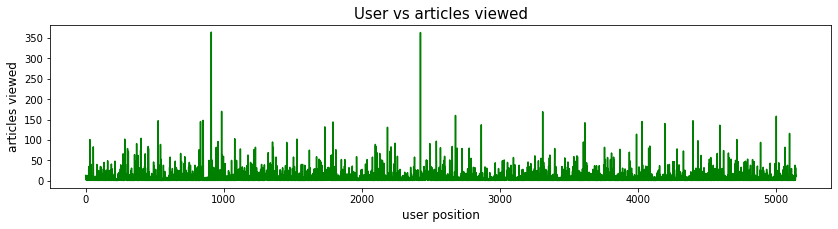

In [ ]:
y_axis = df_inter.groupby('email').count().values

#source: matplotlib documentation for plot at
#https://matplotlib.org/2.1.1/api/_as_gen/matplotlib.pyplot.plot.html
plt.figure(figsize=(14,3))
plt.plot(y_axis, color='green')
plt.title('User vs articles viewed', fontsize=15)
plt.ylabel('articles viewed', fontsize=12)
plt.xlabel('user position', fontsize=12);

In [ ]:
# Fill in the median and maximum number of user_article interactions below
median_val = 3 # 50% of individuals interact with 3 of articles or fewer.
max_views_by_user = 364 # The maximum number of user-article interactions by any 1 user is 364.

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [ ]:
print('articles dataframe have originally {} entries'.format(df_article.shape[0]))
df_article.head(1)

articles dataframe have originally 1056 entries


,doc_body,doc_description,doc_full_name,doc_status
article_id,,,,
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live


Finding duplicates:

- Pandas function in [documentation](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.duplicated.html)

In [ ]:
df_article[df_article.index.duplicated()]

,doc_body,doc_description,doc_full_name,doc_status
article_id,,,,
50,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live
221,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live
398,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live
577,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live
232,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live


In [ ]:
df_article = df_article[~df_article.index.duplicated()]
print('articles dataframe have now {} entries'.format(df_article.shape[0]))
df_article.head(1)

articles dataframe have now 1051 entries


,doc_body,doc_description,doc_full_name,doc_status
article_id,,,,
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live


`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.

In [ ]:
len(set(df_inter.index))


714

**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>

In [ ]:
df_article.shape[0]

1051

**c.** The number of unique users in the dataset. (excluding null values) <br>

In [ ]:
#my little test to catch this little Joker over here...
#based on this article (not without some  blood, sweat and tears)
#https://appdividend.com/2019/08/16/null-object-in-python-example-python-null-value-tutorial/#:~:text=There's%20no%20null%20in%20Python,use%20a%20None%20value%20(types.
users = set(df_inter['email'])
for user in users:
    try: 
        if len(user) == 0:
            print('*an empty user was found:', user)
    except TypeError:
        print('*an invalid user ID was found:', user)

*an invalid user ID was found: nan


In [ ]:
len(users) - 1

5148

**d.** The number of user-article interactions in the dataset.

In [ ]:
df_inter.shape[0]

45993

In [ ]:
unique_articles = 714 # The number of unique articles that have at least one interaction
total_articles = 1051 # The number of unique articles on the IBM platform
unique_users = 5148 # The number of unique users
user_article_interactions = 45993 # The number of user-article interactions

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [ ]:
df_usr = df_inter['email']
most_readed = df_usr.groupby(by=df_usr.index).count().sort_values(ascending=False)
most_readed.head(10)

article_id
1429    937
1330    927
1431    671
1427    643
1364    627
1314    614
1293    572
1170    565
1162    512
1304    483
Name: email, dtype: int64

In [ ]:
most_viewed_article_id = '1429.0' # The most viewed article in the dataset as a string with one value following the decimal 
max_views = 937 # The most viewed article in the dataset was viewed how many times?

In [ ]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column
#########1#########2#########3#########4#########5#########6#########7#########8
def fn_email_mapper(df_input,
                    verbose=False):
    '''This function maps the user e-mail to a user ID. Then e-mail column will
    be removed. This is a standard function on this notebook
    Inputs:
      - df_input (mandatory) - your relationship dataframe (Pandas Dataframe)
      - verbose (optional) - if you want some verbosity on this process, please
      turn it on (default=False)
    Output:
      - df_output - your relationship dataframe, modified (Pandas Dataframe)
    '''
    if verbose:
      print('###e-mail mapper function started')
    #just to prevent modifying the original dataframe  
    df_output = df_input.copy()#deep=True)
    coded_dict = dict()
    cter = 1
    ls_encoded = []
    
    for val in df_output['email']:
        #if verbose:
        #    print('iteration')
        if val not in coded_dict:
            if verbose:
              print('*for value {} it was append {}'.format(val, cter))
            coded_dict[val] = cter
            cter+=1
        ls_encoded.append(str(coded_dict[val]))

    #exclude old column and add the new one
    del df_output['email']
    df_output['user_id'] = ls_encoded    

    return df_output

function `df_inter_enc` created!

In [ ]:
df_inter_enc = udc3.fn_email_mapper(
                   df_input=df_inter,
                   verbose=False
)

Only run this if you need to run it locally:

In [ ]:
#df_inter_enc = fn_email_mapper(
#                   df_input=df_inter,
#                   verbose=False)

In [ ]:
df_inter_enc.tail(5)

,title,user_id
article_id,,
1324,ibm watson facebook posts for 2015,5146
142,neural networks for beginners: popular types a...,5146
233,bayesian nonparametric models – stats and bots,5147
1160,analyze accident reports on amazon emr spark,5148
16,higher-order logistic regression for large dat...,5149


In [ ]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [ ]:
df_inter_enc.head(1)

,title,user_id
article_id,,
1430,"using pixiedust for fast, flexible, and easier...",1


In [ ]:
df_inter_enc.dtypes

title      object
user_id    object
dtype: object

Only to see in another way:    


In [ ]:
df_inter_enc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45993 entries, 1430 to 16
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    45993 non-null  object
 1   user_id  45993 non-null  object
dtypes: object(2)
memory usage: 2.3+ MB


In [ ]:
df_inter_enc['title'].value_counts()[:10]

use deep learning for image classification                            937
insights from new york car accident reports                           927
visualize car data with brunel                                        671
use xgboost, scikit-learn & ibm watson machine learning apis          643
predicting churn with the spss random tree algorithm                  627
healthcare python streaming application demo                          614
finding optimal locations of new store using decision optimization    572
apache spark lab, part 1: basic concepts                              565
analyze energy consumption in buildings                               512
gosales transactions for logistic regression model                    483
Name: title, dtype: int64

In [ ]:
df_inter_enc.index.value_counts()[:10]#.index.tolist()

1429    937
1330    927
1431    671
1427    643
1364    627
1314    614
1293    572
1170    565
1162    512
1304    483
Name: article_id, dtype: int64

Why to return an **Index** instead of just a **List**?

- basically they are the same thing, an object carrying some text strings

- but, just imagine that in this case, each of these strings can be used to **retrieve data** from a dataframe. And in this case, an **Index** normally is recommended, instead of just using a List. 

In [ ]:
df_inter_enc['title'].value_counts()[:10].index

Index(['use deep learning for image classification',
       'insights from new york car accident reports',
       'visualize car data with brunel',
       'use xgboost, scikit-learn & ibm watson machine learning apis',
       'predicting churn with the spss random tree algorithm',
       'healthcare python streaming application demo',
       'finding optimal locations of new store using decision optimization',
       'apache spark lab, part 1: basic concepts',
       'analyze energy consumption in buildings',
       'gosales transactions for logistic regression model'],
      dtype='object')

Just observe another thing. I allways use **singular** to designate variables. Why? In the past, we used to program in very, very old computers, that run Pascal 3. So you needed to do a lot of steps before having something to test. And then you messed a single variable, just because you stucked in designating it "dogs" and not "dog". And in the middle of a lot of messy code, you forgot and called it by the singular! So, this is an only short story, but for the same reason I like to start my functions with this weird **fn_** prefix, just to remember that I am calling my own function (and not a kind of a special command in my programming language). 

In [ ]:
#########1#########2#########3#########4#########5#########6#########7#########8
def fn_get_top_article(df,
                       num_art=10,
                       as_index=True,
                       verbose=False):
    '''This function takes a dataframe of user vs articles interactions and
    return the titles of the most accessed ones. 
    
    Inputs:
      - df (mandatory) -  is a kind of df_inter_enc (intermediary encoded)
        dataframe type (Pandas Dataframe)
      - num_art - (optional) - the number of most accessed articles in the 
        dataframe (Integer, default=10)
      - as_index - if you want to return it as an Pandas Index, instead of a 
        list (default=True)
      - verbose (optional) - if you want some verbosity in your function -
        (Boolean, default=False)
    Output:
      - top_article - (list) A list of the top 'n' article titles 
    '''
    if verbose:
        print('###function get top articles started')  

    start = time()
    most_art = df['title'].value_counts()[:num_art].index

    if not as_index:
        most_art = most_art.tolist()

    end = time()

    if verbose:
        print('elapsed time: {:.6f}s'.format(end-start))
    
    return most_art #article titles only

In [ ]:
#########1#########2#########3#########4#########5#########6#########7#########8
def fn_get_top_article_id(df, 
                          num_art=10,
                          as_index=True,
                          verbose=False):
    '''This function takes a dataframe of user vs articles interactions and
    return the titles of the most accessed ones. 
    
    Inputs:
      - df (mandatory) -  is a kind of df_inter_enc (intermediary encoded)
        dataframe type (Pandas Dataframe)
      - num_art - (optional) - the number of most accessed articles in the 
        dataframe (Integer, default=10)
      - as_index - if you want to return it as an Pandas Index, instead of a 
        list (default=True)   
      - verbose (optional) - if you want some verbosity in your function -
        (Boolean, default=False)
    Output:
      - top_article - (list) A list of the top 'n' article titles
    '''
    if verbose:
        print('###function get top articles started')        
 
    start = time()
    most_art = df.index.value_counts()[:num_art].index

    if not as_index:
        most_art = most_art.tolist()

    end = time()

    if verbose:
        print('elapsed time: {:.6f}s'.format(end-start))
 
    return most_art #most accessed articles ids

function `fn_get_top_article` created!

function `fn_get_top_article_id` created!

In [ ]:
print(udc3.fn_get_top_article(
          df=df_inter_enc,
          num_art=10,
          as_index=True,
          verbose=True
))
print()
print(udc3.fn_get_top_article_id(
          df=df_inter_enc,
          num_art=10,
          as_index=True,
          verbose=True
))

###function get top articles started
elapsed time: 0.008533s
Index(['use deep learning for image classification',
       'insights from new york car accident reports',
       'visualize car data with brunel',
       'use xgboost, scikit-learn & ibm watson machine learning apis',
       'predicting churn with the spss random tree algorithm',
       'healthcare python streaming application demo',
       'finding optimal locations of new store using decision optimization',
       'apache spark lab, part 1: basic concepts',
       'analyze energy consumption in buildings',
       'gosales transactions for logistic regression model'],
      dtype='object')

###function get top articles started
elapsed time: 0.001360s
Int64Index([1429, 1330, 1431, 1427, 1364, 1314, 1293, 1170, 1162, 1304], dtype='int64')


If you need to run this functions locally, please uncoment:

In [ ]:
#print(fn_get_top_article(
#          df=df_inter_enc,
#          num_art=10,
#          as_index=True,
#          verbose=True))
#print()
#print(fn_get_top_article_id(
#          df=df_inter_enc,
#          num_art=10,
#          as_index=True,
#          verbose=True))

In [ ]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = udc3.fn_get_top_article(
             df=df_inter_enc,
             num_art=5,
             as_index=True,
             verbose=False
)
top_10 = udc3.fn_get_top_article(
             df=df_inter_enc,
             num_art=10,
             as_index=True,
             verbose=False
)
top_20 = udc3.fn_get_top_article(
             df=df_inter_enc,
             num_art=20,
             as_index=True,
             verbose=False
)

If you need to run these functions locally, please uncomment:

In [ ]:
# Test your function by returning the top 5, 10, and 20 articles
#top_5 = fn_get_top_article(
#             df=df_inter_enc,
#             num_art=5,
#             as_index=True,
#             verbose=False)
#top_10 = fn_get_top_article(
#             df=df_inter_enc,
#             num_art=10,
#             as_index=True,
#             verbose=False)
#top_20 = fn_get_top_article(
#             df=df_inter_enc,
#             num_art=20,
#             as_index=True,
#             verbose=False)

Just to pass into the test function, I created this variation, with the correct name. And df in my original function I pass the datase, just to process data observing the principle of **purity** of Functional Programming.

In [ ]:
#short version - don't use it!
#########1#########2#########3#########4#########5#########6#########7#########8
def get_top_articles(num_art,
                     as_index=True,
                     verbose=False):
    if verbose:
        print('###function get top articles started')  
    start = time()
    most_art = df['title'].value_counts()[:num_art].index
    if not as_index:
        most_art = most_art.tolist()
    end = time()
    if verbose:
        print('elapsed time: {:.6f}s'.format(end-start))
    return most_art

In [ ]:
# Test each of your three lists from above
df = df_inter_enc
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

first, I want my **Users ID** in a fancy format, so I will use my **mapper** function, already created earlier:

In [ ]:
df_inter_enc = udc3.fn_email_mapper(
                   df_input=df_inter,
                   verbose=False
)
df_inter_enc.head(1)

,title,user_id
article_id,,
1430,"using pixiedust for fast, flexible, and easier...",1


This solution is based on Pandas documentation [here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html) and in earlier Udacity exercises, creating a user x movie preference matrix.

In [ ]:
group = df_inter_enc.groupby(by=['user_id', df_inter_enc.index])['title'].count()
group

user_id  article_id
1        43            1
         109           1
         151           1
         268           1
         310           2
                      ..
999      1274          1
         1314          1
         1354          1
         1393          1
         1398          1
Name: title, Length: 33682, dtype: int64

In [ ]:
group = group.unstack()
group.head(1)

article_id,0,2,4,8,9,12,14,15,16,18,20,25,26,28,29,30,32,33,34,36,39,40,43,48,50,51,53,54,57,58,59,60,62,64,65,68,74,76,77,78,...,1402,1403,1404,1405,1406,1407,1408,1409,1410,1411,1412,1414,1415,1416,1418,1419,1420,1421,1422,1423,1424,1425,1426,1427,1428,1429,1430,1431,1432,1433,1434,1435,1436,1437,1439,1440,1441,1442,1443,1444
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,2.0,2.0,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN


First method, costed like **6 seconds** to run:

- the idea is to correct the dataframe, to contain only zeroes and ones

In [ ]:
begin = time()

for col in group:
    group[col] = group[col].apply(lambda x: 0 if pd.isnull(x) else 1)

end = time()
print('spent {:.4f}s'.format(end-begin))

group.head(1)

spent 6.7539s


article_id,0,2,4,8,9,12,14,15,16,18,20,25,26,28,29,30,32,33,34,36,39,40,43,48,50,51,53,54,57,58,59,60,62,64,65,68,74,76,77,78,...,1402,1403,1404,1405,1406,1407,1408,1409,1410,1411,1412,1414,1415,1416,1418,1419,1420,1421,1422,1423,1424,1425,1426,1427,1428,1429,1430,1431,1432,1433,1434,1435,1436,1437,1439,1440,1441,1442,1443,1444
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,1,0,0,0,0,1,0,1,0,0,0,0,0


Second method:    

- first I fill NaN with zeroes

- then change everything that is not zero with an 1

And it took only as **1.2 seconds**, so it is much faster!

In [ ]:
group = df_inter_enc.groupby(by=['user_id', 
                                 df_inter_enc.index])['title'].count().unstack()
begin = time()
group = group.fillna(0)

for col in group:
    group[col] = group[col].apply(lambda x: x if x == 0 else 1)

end = time()
print('spent {:.4f}s'.format(end-begin))

group.head(1)

spent 1.3723s


article_id,0,2,4,8,9,12,14,15,16,18,20,25,26,28,29,30,32,33,34,36,39,40,43,48,50,51,53,54,57,58,59,60,62,64,65,68,74,76,77,78,...,1402,1403,1404,1405,1406,1407,1408,1409,1410,1411,1412,1414,1415,1416,1418,1419,1420,1421,1422,1423,1424,1425,1426,1427,1428,1429,1430,1431,1432,1433,1434,1435,1436,1437,1439,1440,1441,1442,1443,1444
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#########1#########2#########3#########4#########5#########6#########7#########8
def fn_create_user_item_matrix(df,
                               verbose=True):
    '''This function returns a matrix with user ids as rows and article ids on 
    the columns with 1 values where a user interacted with  an article and a 0. 
    Otherwise create the user-article matrix with 1's and 0's.
    
    Inputs:
      - df (mandatory) - pandas dataframe in the format of df_inter_enc,
        having article_id as index, plus title and user_id columns
      - verbose (optional) - if you want some verbosity in your function -
        (Boolean, default=False)
    Output:
      - df_out - user-item matrix, having users as rows and articles as column,
        maximum value allowed is 1 for each entry. 
    '''
    if verbose:
        print('###function create user item matrix started')
    
    #my correction subfunction
    def _(x):
      if x == 0:
        return x
      else:
        return 1
    
    #only to avoid modifying the original dataframe
    df_out = df.copy()
    start = time()

    #step 1: creating the user-item matrix
    group = df_out.groupby(by=['user_id', df_out.index])['title'].count()
    group = group.unstack()

    #step 2: ensuring that there will be no NaNs in dataframe
    group = group.fillna(0)

    #step 3: ensuring that the only possible values will be 0 or 1
    for article in group:
        group[article] = group[article].apply(_(x))
    
    end = time()
    
    if verbose:
        print('elapsed time: {:.4f}s'.format(end-start))
    
    return group #user-item dataframe

function `fn_create_user_item_matrix` created!

Obs: I know that I already have a `fn_create_user_item` from earlier Udacity studies on movies in my library! The idea is in a near future to compare them and melt them together. 

In [ ]:
df_user_item = udc3.fn_create_user_item_matrix(
                df=df_inter_enc,
                verbose=True
)
df_user_item.head(1)

###function create user item matrix started
user matrix has 5149 users (rows) and 714 articles (columns)
elapsed time: 1.2498s


article_id,0,2,4,8,9,12,14,15,16,18,20,25,26,28,29,30,32,33,34,36,39,40,43,48,50,51,53,54,57,58,59,60,62,64,65,68,74,76,77,78,...,1402,1403,1404,1405,1406,1407,1408,1409,1410,1411,1412,1414,1415,1416,1418,1419,1420,1421,1422,1423,1424,1425,1426,1427,1428,1429,1430,1431,1432,1433,1434,1435,1436,1437,1439,1440,1441,1442,1443,1444
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


I am not sure if it will not be better to create a True/False (Boolean) array, instead of a 0/1 (and Floating!) matrix! Later I will need to make a deeper analysis on these possibilities.

In [ ]:
df_user_item.sum(axis=1)[1]

19.0

In [ ]:
## Tests: You should just need to run this cell.  Don't change the code.
assert df_user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert df_user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert df_user_item.sum(axis=1)[1] == 19, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [ ]:
print('{} users versus {} articles'.format(df_user_item.shape[0], df_user_item.shape[1]))
df_user_item.head(1)

5149 users versus 714 articles


article_id,0,2,4,8,9,12,14,15,16,18,20,25,26,28,29,30,32,33,34,36,39,40,43,48,50,51,53,54,57,58,59,60,62,64,65,68,74,76,77,78,...,1402,1403,1404,1405,1406,1407,1408,1409,1410,1411,1412,1414,1415,1416,1418,1419,1420,1421,1422,1423,1424,1425,1426,1427,1428,1429,1430,1431,1432,1433,1434,1435,1436,1437,1439,1440,1441,1442,1443,1444
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


**User 1 preferences** is represented by a **sparse** vector:

In [ ]:
df_user_item.loc['1'].head()

article_id
0    0.0
2    0.0
4    0.0
8    0.0
9    0.0
Name: 1, dtype: float64

Seen articles:

In [ ]:
user = df_user_item.loc['1']
valid= user[user == 1].count()
tot= len(user)
per = 100. * (valid / tot)
print ('for user 1 we have {} accessed articles ({:.2f})% in a world of {} articles'\
       .format(valid, per, tot))

for user 1 we have 36 accessed articles (5.04)% in a world of 714 articles


In [ ]:
df_user_item.dot(user)

user_id
1       36.0
10       7.0
100      0.0
1000     0.0
1001     1.0
        ... 
995      4.0
996      2.0
997      0.0
998      3.0
999      0.0
Length: 5149, dtype: float64

Pandas dot product [documentation](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.dot.html):    

- it is a method for an array-like object (more espefically, a Pandas Dataframe containing only numbers);

- so, we apply the method over the object (in this case, our huge **user_item** sparse matrix) versus another matrix, or vector;

- for a vector, it returns a vector, in each dimmension of the vector containing a specific value (the dot product) for each **colum** of the object (in this case, other users).

So, for User 1 is very similar to **himself**! ;-)

In [ ]:
user_id = '3933' #1
similar = df_user_item.dot(df_user_item.loc[user_id])
print('similar (the dot product) is a vector')
print('it have the same length of the number of users:', 
      similar.shape[0])

similar.head(5)

similar (the dot product) is a vector
it have the same length of the number of users: 5149


user_id
1       35.0
10       7.0
100      0.0
1000     0.0
1001     1.0
dtype: float64

User 1 is also very similar to **User 3933**!

- ordering it we will have an idea of the most similar users to User 1

In [ ]:
similar = similar.drop('1') #bye bye himself!
similar_most = similar.sort_values(ascending=False)
similar_most.head(5)

user_id
3933    35.0
3782    17.0
23      17.0
203     15.0
4459    15.0
dtype: float64

The task says to create a **complete** list of users, but that is not so clever! When I navigate through the list, I can notice that it goes to zero really fast (even for a very active user, as User 1).

It makes sense, as the dot product of two vectors, one (or both of them) being zero is equal to **zero**! 

In [ ]:
similar_lst = similar_most.index.to_list()
similar_lst[0]

'3933'

Only to ensure that the search for an user will use allways the **string** format of data for indexes:

In [ ]:
str('1')

'1'

In [ ]:

#########1#########2#########3#########4#########5#########6#########7#########8
def fn_find_similar_user(df_user_item,
                         user_id,
                         max_usr=None,
                         verbose=False):
    '''This function takes a user_item matrix and calculates the dot product 
    (Cartesian product) between a user vector and the user_item matrix. The 
    idea is to compute how similars two users are.

    If you think about the geometry behind this opperation, just imagine that
    each item (in this case, an article) is a dimension in a n-dimensional
    Cartesian space. Then consider each user as a vector. If a user viewed one
    item, it expresses in that dimension as a 1. Else, he left no traces in that
    dimmension.

    So, the same thing with the second, and the third user, and so on. If this
    other user have one dimmension in common, both had an expression in one of
    the n-dimmensional space produced by the items. More dimmensions they have
    in common, more they are simmilars!

    The Pandas Cartesian product method let us make a huge computation, creating
    a vector, containing in each row the information about the result of the
    interaction with the user self vector and all the other vectors in the user-
    item matrix.

    One thing to consider is as this is a mathematical modelling, it also
    produces the dot product of self-by-self. So we need to elliminate this
    record, as it does not make sense for our purposes. (an user cannot take 
    himself as a nice recommendation source)

    And finally, we expect that the most similar users (same past preferences)
    could give us good insights for a new item to recommend to our user. (kind 
    of the "past" of an user with similar preferences can be the "future" for 
    our actual user)
    
    Inputs:
    - user_item (mandatory) - (pandas dataframe) matrix of users by articles: 
      1's when a user has interacted with an article, 0 otherwise with index and
      column names in numerical string format
    - user_id (mandatory) - (int) a user_id
    - num_max (optional) - if you want to inform the maximum number of entries
      that you wish for your list (default=None)
    - verbose (optional) - if you want some verbosity during the processing
      (default=False)
    Output:
    - similar_user - (list) an ordered list where the closest users 
      (largest dot product users) are listed first
    '''
    if verbose:
        print('###function find similar users started')

    start = time()
    user = df_user_item.loc[str(user_id)] #ID is string

    if verbose:
        print('user {} has {} articles viewed'\
              .format(user_id, user[user == 1].count()))

    #first, compute the similarity
    similar = df_user_item.dot(user) #for each user -> provided user
    #second, remove his own ego from the series
    similar = similar.drop('1') #bye bye himself!
    #third, sort by similarity
    similar_most = similar.sort_values(ascending=False)

    if verbose:
        print('*for reference: 10th value is', similar_most[9])
    
    #restrict maximum number of entries
    if max_usr is not None:
        similar_most = similar_most[:max_usr]

    if verbose:
        print('returning list of {} max users'.format(max_usr))

    #finally, take an id list
    similar_lst = similar_most.index.to_list()

    end = time()
    if verbose:
        print('elapsed time: {:.4f}s'.format(end-start))

    return similar_lst #users ids in order from most to least similar   

function `fn_find_similar_user` created!

In [ ]:
udc3.fn_find_similar_user(
    df_user_item=df_user_item,
    user_id='1',
    max_usr=10,
    verbose=True
)

###function find similar users started
user 1 has 36 articles viewed
*for reference: 10th value is 12.0
returning list of 10 max users
elapsed time: 0.0272s


['3933', '3782', '23', '4459', '203', '131', '3870', '46', '4201', '3697']

In [ ]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}"\
      .format(udc3.fn_find_similar_user(
                  df_user_item=df_user_item,
                  user_id=1,
                  verbose=True)[:10]))
print("The 5 most similar users to user 3933 are: {}"\
      .format(udc3.fn_find_similar_user(
                  df_user_item=df_user_item,
                  user_id=3933,
                  verbose=True)[:5]))
print("The 3 most similar users to user 46 are: {}"\
      .format(udc3.fn_find_similar_user(
                  df_user_item=df_user_item,
                  user_id=46,
                  verbose=True)[:3]))

###function find similar users started
user 1 has 36 articles viewed
*for reference: 10th value is 12.0
returning list of None max users
elapsed time: 0.0163s
The 10 most similar users to user 1 are: ['3933', '3782', '23', '4459', '203', '131', '3870', '46', '4201', '3697']
###function find similar users started
user 3933 has 35 articles viewed
*for reference: 10th value is 12.0
returning list of None max users
elapsed time: 0.0115s
The 5 most similar users to user 3933 are: ['3933', '3782', '23', '203', '4459']
###function find similar users started
user 46 has 40 articles viewed
*for reference: 10th value is 16.0
returning list of None max users
elapsed time: 0.0109s
The 3 most similar users to user 46 are: ['4201', '46', '23']


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

For **User 1**, find all items (articles) that had some interest to him.

In [ ]:
start = time()
article = df_user_item.loc['1'][df_user_item.loc['1'] == 1]
end = time()
print('elapsed time: {:.6f}s'.format(end-start))

article.head(5)

elapsed time: 0.001948s


article_id
43     1.0
109    1.0
151    1.0
268    1.0
310    1.0
Name: 1, dtype: float64

In [ ]:
ls1 = article.index.tolist()[0:5]
ls1

[43, 109, 151, 268, 310]

Checking if the max number exceeds the list length, if it breaks:

In [ ]:
ls1[:10]

[43, 109, 151, 268, 310]

We could use as source for extracting the tile both **df_inter_enc** or **df_article**:

- **df_article** is the speciallized dataframe for articles, and it must be considered the **most realliable** source of data

- **df_article** also have a considerable less number of entries (as they could not repeat), so the search is faster

- comment on functions tells us about using **df_article** kind of dataframe, so this will be our choice!

In [ ]:
df_article['doc_full_name'].head(1)

article_id
0    Detect Malfunctioning IoT Sensors with Streami...
Name: doc_full_name, dtype: object

In [ ]:
df_inter_enc['title'].head(1)

article_id
1430    using pixiedust for fast, flexible, and easier...
Name: title, dtype: object

In [ ]:
ls2 = article.index.tolist()[0:10]
ls2

[43, 109, 151, 268, 310, 329, 346, 390, 494, 525]

My new method, using Pandas Filter:

In [ ]:
df_article.head(1)

,doc_body,doc_description,doc_full_name,doc_status
article_id,,,,
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live


In [ ]:
art = df_article.filter(items=ls2, axis=0)['doc_full_name']

In [ ]:
art.values.tolist()

['Deep Learning With Tensorflow Course by Big Data University',
 'TensorFlow Quick Tips',
 'Jupyter Notebook Tutorial',
 'Sector Correlations Shiny App',
 'Time Series Prediction Using Recurrent Neural Networks (LSTMs)',
 'Introduction to Market Basket Analysis in\xa0Python',
 'Fighting Gerrymandering: Using data science to draw fairer congressional districts',
 'Introducing IBM Watson Studio ',
 'Python For Loops Explained (Python for Data Science Basics #5)',
 'New Shiny cheat sheet and video tutorial']

My old method (linear), iterating each item from a list

In [ ]:
#for article in ls2:
entry = df_article[df_article.index == 43]['doc_full_name']
#entry.__dir__()
entry.values[0]

'Deep Learning With Tensorflow Course by Big Data University'

In [ ]:
#########1#########2#########3#########4#########5#########6#########7#########8
def fn_get_article_name(df,
                        ls_article,
                        alternative_df=False, 
                        verbose=False):
    '''This function takes the articles IDs and return a list of the articles
    titles.
    
    Inputs:
      - df (mandatory) - an article detailing dataframe (Panda Dataframe)
        *option 1: df_inter_enc (default) - dataset for working
        *option 2: df_article (alternative) - an alternative dataset
      - ls_article (mandatory) - a list of article ids (Python List)
      - alternative_df (optional) - if you want to work with df_article, please
        check it as True - (boolean, default=False)
      - verbose (optional) - if you want some verbosity in your function -
        (Boolean, default=False)
    Output:
      - art_name - a list of the name of the articles (Python List)
    '''
    if verbose:
        print('###get article name started')        

    start = time()

    #improving robustness of the system
    ls_aux = []
    for art in ls_article:
        ls_aux.append(int(float(art)))
    ls_article = ls_aux
    
    if alternative_df: #df_article
        if verbose:
            print('working with df_article type of dataframe')
        art = df.filter(items=ls_article, axis=0)['doc_full_name'] #collecting
        art_name = art.values.tolist()
    else: #df_inter_enc
        if verbose:
            print('working with df_inter_enc type of dataframe')
        art_name = []

        for art_id in ls_article: #collecting names
            art_name.append(df[df.index == art_id]['title'].values[0])   
    
    end = time()

    if verbose:
        print('elapsed time: {:.6f}s'.format(end-start))
    
    return art_name #articles names for articles IDs

function `fn_get_article_name` created!

**Special Note**

I noticed that I prepared this `fn_get_article_name` function to work with the `df_article` dataset. When I go to the validation, I noticed that it works well with the values from `df_inter_enc` dataset.

So, I adapted the function to work with **both** datasets. In a near future it can be valuable, as `df_article` dataset is more robust for this kind of data.

In [ ]:
ls_article = [1024, 1176, 1305, 1314, 1422, 1427]

df = df_inter_enc
for art_id in ls_article:
  print(df[df.index == art_id]['title'].values[0])

using deep learning to reconstruct high-resolution audio
build a python app on the streaming analytics service
gosales transactions for naive bayes model
healthcare python streaming application demo
use r dataframes & ibm watson natural language understanding
use xgboost, scikit-learn & ibm watson machine learning apis


Improving the robustness:

- accepting **variable input** formats (it can deal with them)

- in this case, taking data from `df_article` dataframe (**not** the default)

In [ ]:
#ls2 = [43, 109, 151, 268, 310, 329, 346, 390, 494, 525]
#ls2 = [43.0, 109.0, 151.0, 268.0, 310.0, 329.0, 346.0, 390.0, 494.0, 525.0]
#ls2 = ['43', '109', '151', '268', '310', '329', '346', '390', '494', '525']
ls2 = ['43.0', '109.0', '151.0', '268.0', '310.0', '329.0', '346.0', '390.0', '494.0', '525.0']

#ls_aux = []
#for art in ls2:
#    ls_aux.append(int(float(art)))
#ls2 = ls_aux

udc3.fn_get_article_name(
    df=df_article,
    ls_article=ls2,
    alternative_df=True,
    verbose=True
)

###get article name started
working with df_article type of dataframe
elapsed time: 0.001356s


['Deep Learning With Tensorflow Course by Big Data University',
 'TensorFlow Quick Tips',
 'Jupyter Notebook Tutorial',
 'Sector Correlations Shiny App',
 'Time Series Prediction Using Recurrent Neural Networks (LSTMs)',
 'Introduction to Market Basket Analysis in\xa0Python',
 'Fighting Gerrymandering: Using data science to draw fairer congressional districts',
 'Introducing IBM Watson Studio ',
 'Python For Loops Explained (Python for Data Science Basics #5)',
 'New Shiny cheat sheet and video tutorial']

Testing for our **main** dataset:

- `df_inter_enc` in now our source of data (default)

In [ ]:
#ls2 = [43, 109, 151, 268, 310, 329, 346, 390, 494, 525]
#ls2 = ['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0']
#ls2= ['1024', '1176', '1305', '1314', '1422', '1427']
ls2 = [1024, 1176, 1305, 1314, 1422, 1427]

udc3.fn_get_article_name(
    df=df_inter_enc,
    ls_article=ls2,
    alternative_df=False,
    verbose=True
)

###get article name started
working with df_inter_enc type of dataframe
elapsed time: 0.013850s


['using deep learning to reconstruct high-resolution audio',
 'build a python app on the streaming analytics service',
 'gosales transactions for naive bayes model',
 'healthcare python streaming application demo',
 'use r dataframes & ibm watson natural language understanding',
 'use xgboost, scikit-learn & ibm watson machine learning apis']

In [ ]:
#########1#########2#########3#########4#########5#########6#########7#########8
def fn_get_user_article(df_user_item,
                        df_article,
                        user_id, 
                        max_art=10,
                        verbose=False):
    '''This function gives a list of article_ids and article titles that have 
    been seen by a user.
    
    Inputs:
      - df_user_item (mandatory) - a previously processed dataframe of users by 
        articles (Pandas Dataframe)
        *it have an 1 when the article was viewed by an user (Pandas Dataframe)
       - df_article (mandatory) - an article detailing dataframe 
        (Panda Dataframe)       
      - user_id (mandatory) - an user id (Integer/String)
      - max_art (optional) - maximum number of articles for each 
        (one user per time) - (default=None)
      - verbose (optional) - if you want some verbosity in your function -
        (Boolean, default=False)
    Outputs:
      - ls_id - (list) a Python list of the article ids accessed by the user
      - ls_name - (list) a list of the names of the articles 
        (this is identified by the doc_full_name column in df_article)    
    '''
    if verbose:
        print('###function get user article started')
        
    start = time()

    #first, get article IDs that were rellevant to an user
    article = user_item.loc[str(user_id)][df_user_item.loc[str(user_id)] == 1]
    ls_id = article.index.tolist()[0:max_art]

    if verbose:
        print('return format: {} items'.format(max_art))

    #second, get articles names
    #you can alter this calling for using the alternative dataset!
    ls_name = fn_get_article_name(
                  df=df_inter_enc,
                  ls_article=ls_id,
                  alternative_df=False,
                  verbose=verbose
    )
    end = time()
    
    if verbose:
        print('elapsed time: {:.4f}s'.format(end-start))
    
    return ls_id, ls_name #list of ids and names

function `fn_get_user_article` created!

Enhancing `fn_get_user_article` to give ids list in string format too:

In [ ]:
list_aux = []

list_test = [43, 109, 151, 268, 310, 329, 346, 390, 494, 525]
for item in list_test:
    list_aux.append(str(item))

list_test = list_aux
list_test

['43', '109', '151', '268', '310', '329', '346', '390', '494', '525']

In [ ]:
udc3.fn_get_user_article(
    df_user_item=df_user_item,
    df=df_inter_enc,
    user_id=1, 
    max_art=10,
    id_as_str=True,
    verbose=True
)

###function get user article started
return format: 10 items
###get article name started
working with df_inter_enc type of dataframe
elapsed time: 0.019169s
returning articles IDs as strings
elapsed time: 0.0220s


(['43', '109', '151', '268', '310', '329', '346', '390', '494', '525'],
 ['deep learning with tensorflow course by big data university',
  'tensorflow quick tips',
  'jupyter notebook tutorial',
  'sector correlations shiny app',
  'time series prediction using recurrent neural networks (lstms)',
  'introduction to market basket analysis in\xa0python',
  'fighting gerrymandering: using data science to draw fairer congressional districts',
  'introducing ibm watson studio ',
  'python for loops explained (python for data science basics #5)',
  'new shiny cheat sheet and video tutorial'])

Sketch for adding recommendations:

In [ ]:
max_rec = 10
rec_art = [1, 2, 3, 4, 5, 6]
#rec_art = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
#rec_art = []
#rec_new = ['1b', '2b', '3b', '4b', '5b', '6b']
rec_new = []

more = max_rec - len(rec_art)
if more > 0:
    print('more', more)
    rec_art += rec_new[:more]

if len(rec_art) == max_rec:
    print('return result')
elif len(rec_art) > max_rec:
    raise Exception('something went wrong with recommendations')

rec_art

more 4


[1, 2, 3, 4, 5, 6]

In [ ]:
#ls1 = ['1', '2', '3', '4', '5', '6']
#ls2 = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
#ls1 = []
ls1 = [1, 2, 3, 4, 5, 6]
ls2 = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
rec_new = np.setdiff1d(np.asarray(ls1), np.asarray(ls2), assume_unique=True)
rec_new
np.asarray(ls1)

array([1, 2, 3, 4, 5, 6])

In [ ]:
set(ls1) ^ set(ls2)

{7, 8, 9, 10}

In [ ]:
#########1#########2#########3#########4#########5#########6#########7#########8
def fn_user_user_rec(df_user_item,
                     df_article,
                     user_id,
                     max_art=None,
                     max_usr=None,
                     max_rec=10,
                     verbose=False):
    '''This function takes and user and gives recommendations of new articles 
    for him. The engine is based on cartesian (dot product) similarity.
    
    It works in this way:
    1. First, I give a user-item matrix (preprocessed), and one user id;
    2. Then, the system goes into the user-item matrix and retrieves all the
       articles viewed by this user and stores it (we don´t want to recommend as
       a new article something the user has already viewed!);
    3. In sequence, the system calculates the dot product for the user-item
       matrix vs specific user vector and order it by the better value,
       decreasing and gives the list of the most similar users for this user;
    4. And then, the systems iterate into the first most similar user, takes the
       viewed articles by him and it they were not already been viewed by the
       main user, then store it for recommendation;
    5. Finally, if the recommendation list was not already complete, then the
       system goes into de second most similar user and so on.

    If the possibilities exausted and we had not found a complete recommendation
    list, we just give up and give an incomplete (or in the worst case, a empty
    list for recommendations for this user, based on users similarity).    
    
    Inputs:
      - df_user_item (mandatory) - a previously processed dataframe of users by 
        articles (Pandas Dataframe)
        *it have an 1 when the article was viewed by an user (Pandas Dataframe)
       - user_id (mandatory) - an user id (Integer/String)
       - df_article (mandatory) - an article detailing dataframe 
        (Panda Dataframe)       
      - max_art (optional) - maximum number of articles for each other user
        (one user per time) - (default=None)
      - max_usr (optional) - maximum number of user for each other user
        (one user per time) - (default=None)
      - num_rec (optional) - the maximum number of recommendations you want for 
        the main user - (Integer, default=10)
      - verbose (optional) - if you want some verbosity in your function -
        (Boolean, default=False)
    Output:
      - rec - (list) a list of recommendations for the user
      
    Description:
      Loops through the users based on closeness to the input user_id
      For each user - finds articles the user hasn't seen before and provides them as recs
      Does this until m recommendations are found
    Notes:
      Users who are the same closeness are chosen arbitrarily as the 'next' user
      For the user where the number of recommended articles starts below m 
      and ends exceeding m, the last items are chosen arbitrarily
    '''
    if verbose:
        print('###function user to user recommendations started')        

    start1 = time()
    rec_art = []

    #get articles viewed by the main user
    ls_art_view_id, ls_art_view_name = udc3.fn_get_user_article(
                                           df_user_item=df_user_item,
                                           df_article=df_article,
                                           user_id=user_id, 
                                           max_art=max_art,
                                           verbose=verbose
    )
    ls_sim_user = udc3.fn_find_similar_user(
                      df_user_item=df_user_item,
                      user_id=user_id,
                      max_usr=max_usr,
                      verbose=verbose
    )
    #iterating on new users
    for user in ls_sim_user:
        if verbose:
            print('*searching new articles from user', user)
        ls_sim_art_id, ls_sim_art_name = udc3.fn_get_user_article(
                                           df_user_item=df_user_item,
                                           df_article=df_article,
                                           user_id=user, 
                                           max_art=max_art,
                                           verbose=verbose
        )
        if verbose:
            print('retrieved articles:', ls_sim_art_id)
        #getting different articles from the new user
        #rec_new = np.setdiff1d(
        #              ls_sim_art_id, 
        #              ls_art_view_id, 
        #              assume_unique=True)
        rec_new = list(set(ls_sim_art_id) ^set(ls_art_view_id))
        if verbose:
            print('new arts:', rec_new)
        #adding new recommendations, if they exist    
        if len(rec_new) > 0:
            more = max_rec - len(rec_art)
            rec_art = rec_art + rec_new[:more]
            if verbose:
                print('*adding {} new recommendations from user {}'\
                      .format(more, user))
            #testing for earlier break
            if len(rec_art) == max_rec:
                if verbose:
                    print('*earlier break condition reached')
                break #earlier break condition
            elif len(rec_art) > max_rec:
                raise Exception('something went wrong with recommendations')
    
    end = time()

    if verbose:
        print('elapsed time: {:.6f}s'.format(end-start1))
    
    return rec_art #articles recommendation for this user_id    

In [ ]:
udc3.fn_user_user_rec(
    df_user_item=df_user_item,
    df=df_inter_enc,
    user_id=1,
    max_art=None,
    max_usr=None,
    max_rec=10,
    verbose=True
)

###function user to user recommendations started
###function get user article started
return format: None items
###get article name started
working with df_inter_enc type of dataframe
elapsed time: 0.040640s
elapsed time: 0.0439s
###function find similar users started
user 1 has 36 articles viewed
*for reference: 10th value is 12.0
returning list of None max users
elapsed time: 0.0135s
*searching new articles from user 3933
###function get user article started
return format: None items
###get article name started
working with df_inter_enc type of dataframe
elapsed time: 0.039538s
elapsed time: 0.0421s
retrieved articles: [43, 109, 268, 310, 329, 346, 390, 494, 525, 585, 626, 668, 732, 768, 910, 968, 981, 1052, 1170, 1183, 1185, 1232, 1293, 1305, 1363, 1368, 1391, 1400, 1406, 1427, 1429, 1430, 1431, 1436, 1439]
new arts: [151]
*adding 10 new recommendations from user 3933
*searching new articles from user 3782
###function get user article started
return format: None items
###get article

[151, 1025, 2, 517, 12, 525, 524, 14, 16, 26]

In [ ]:
ls_art_usr1 = udc3.fn_user_user_rec(
                  df_user_item=df_user_item,
                  df=df_inter_enc,
                  user_id=1,
                  max_art=None,
                  max_usr=None,
                  max_rec=10,
                  verbose=False
)
print('Articles for user 1:', ls_art_usr1)

#Checking results - 10 recommendations for User 1
udc3.fn_get_article_name(
    df=df_inter_enc,
    ls_article=ls_art_usr1,
    alternative_df=False,
    verbose=False
)

Articles for user 1: [151, 1025, 2, 517, 12, 525, 524, 14, 16, 26]


['jupyter notebook tutorial',
 'data tidying in data science experience',
 'this week in data science (april 18, 2017)',
 'shaping data with ibm data refinery',
 'timeseries data analysis of iot events by using jupyter notebook',
 'new shiny cheat sheet and video tutorial',
 'data science platforms are on the rise and ibm is leading the way',
 'got zip code data? prep it for analytics. – ibm watson data lab – medium',
 'higher-order logistic regression for large datasets',
 'using machine learning to predict parking difficulty']

In [ ]:
#int(float('43.0'))
#ls2= ['1024', '1176', '1305', '1314', '1422', '1427']
df_article.loc[1024]['doc_full_name']

'Using Deep Learning to Reconstruct High-Resolution Audio'

Testing function enhancement for accomplishing Udacity requisites:

- now `fn_get_user_article` is able to return `user_id` output in both formats, a **long integer** list or a **numeric string**

- other functions of the system have the robustness enough to take both formats as IDs list input

In [ ]:
set(udc3.fn_get_user_article(
        df_user_item=df_user_item,
        df=df_inter_enc,
        user_id=20, 
        max_art=10,
        id_as_str=True,
        verbose=False)[0])

{'1320', '232', '844'}

In [ ]:
set(udc3.fn_get_user_article(
               df_user_item=df_user_item,
               df=df_inter_enc,
               user_id=2, 
               max_art=10,
               id_as_str=True,
               verbose=False
)[0])

{'1024', '1176', '1305', '1314', '1422', '1427'}

In [ ]:
# Test your functions here - No need to change this code - just run this cell
ls_test1 = ['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0']
assert set(udc3.fn_get_article_name(
               df=df_inter_enc,
               ls_article=ls_test1,
               alternative_df=False,
               verbose=False
)) == set(
    ['using deep learning to reconstruct high-resolution audio', 
     'build a python app on the streaming analytics service', 
     'gosales transactions for naive bayes model', 
     'healthcare python streaming application demo', 
     'use r dataframes & ibm watson natural language understanding', 
     'use xgboost, scikit-learn & ibm watson machine learning apis']),\
"Oops! Your the get_article_names function doesn't work quite how we expect."

ls_test2 = ['1320.0', '232.0', '844.0']
assert set(udc3.fn_get_article_name(
               df=df_inter_enc,
               ls_article=ls_test2,
               alternative_df=False,
               verbose=False                               
)) == set(
    ['housing (2015): united states demographic measures',
     'self-service data preparation with ibm data refinery',
     'use the cloudant-spark connector in python notebook']),\
"Oops! Your the get_article_names function doesn't work quite how we expect."

assert set(udc3.fn_get_user_article(
               df_user_item=df_user_item,
               df=df_inter_enc,
               user_id=20, 
               max_art=10,
               id_as_str=True,
               verbose=False
)[0]) == set(['1320', '232', '844'])

print('OK')

assert set(udc3.fn_get_user_article(
               df_user_item=df_user_item,
               df=df_inter_enc,
               user_id=20, 
               max_art=10,
               id_as_str=True,
               verbose=False
)[1]) == set(
    ['housing (2015): united states demographic measures', 
     'self-service data preparation with ibm data refinery',
     'use the cloudant-spark connector in python notebook'])

assert set(udc3.fn_get_user_article(
               df_user_item=df_user_item,
               df=df_inter_enc,
               user_id=2,
               max_art=10,
               id_as_str=True,
               verbose=False
)[0]) == set(['1024', '1176', '1305', '1314', '1422', '1427'])

assert set(udc3.fn_get_user_article(
               df_user_item=df_user_item,
               df=df_inter_enc,
               user_id=2, 
               max_art=10,
               id_as_str=True,
               verbose=False
)[1]) == set(
    ['using deep learning to reconstruct high-resolution audio',
     'build a python app on the streaming analytics service',
     'gosales transactions for naive bayes model',
     'healthcare python streaming application demo',
     'use r dataframes & ibm watson natural language understanding',
     'use xgboost, scikit-learn & ibm watson machine learning apis'])

print("If this is all you see, you passed all of our tests!  Nice job!")

OK
If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.

Translating this to my thinking:

We have an **original** user → get **closer** users

On **closers**:

**old** → only cartesian closenes counts

  - no **secondary** criteria.

**new** → first, cartesian closenes

  - next, for same score **closers**, **activity** counts

  - **activity** concept: a **closer** that read more articles in the total, is a more active guy

* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

Translating:

On **articles retrieved**:

**old** → just get articles from the **closer** that were never accessed by the **original**

**new** → from an **new** articles list, order them by the **most popular** ones

  - **most popular** concept: articles counted as viewed more times, don´t matter if from a single, or multiple different users






Discovering the most **active users**:

In [ ]:
user_activity = df_inter_enc['user_id'].value_counts()
user_activity

23      364
3782    363
98      170
3764    169
203     160
       ... 
4905      1
2333      1
747       1
5071      1
1414      1
Name: user_id, Length: 5149, dtype: int64

In [ ]:
most_active_user = user_activity.sort_values(ascending=False)
most_active_user

23      364
3782    363
98      170
3764    169
203     160
       ... 
3449      1
2468      1
2831      1
2833      1
1414      1
Name: user_id, Length: 5149, dtype: int64

In [ ]:
df_inter_enc.head(1)

,title,user_id
article_id,,
1430,"using pixiedust for fast, flexible, and easier...",1


In [ ]:
article_activity = df_inter_enc['title'].value_counts()
article_activity

most_viewed_article = article_activity.sort_values(ascending=False)
most_viewed_article

use deep learning for image classification                             937
insights from new york car accident reports                            927
visualize car data with brunel                                         671
use xgboost, scikit-learn & ibm watson machine learning apis           643
predicting churn with the spss random tree algorithm                   627
                                                                      ... 
country statistics: market value of publicly traded shares               1
country statistics: natural gas - consumption                            1
country surface area (sq. km)                                            1
create a connection and add it to a project using ibm data refinery      1
the data processing inequality                                           1
Name: title, Length: 714, dtype: int64

Creating a "similar" dataframe:

- this is strongly inspired in the tips in the article "Different ways to create Pandas Dataframe", [here](https://www.geeksforgeeks.org/different-ways-to-create-pandas-dataframe/)

- this is also a process very similar to assemble a kind of **Doctor Frankenstein´s Monster**, so let´s to it **in parts**...

In [ ]:
count_user = df_user_item.shape[0]
print('whe have {} unique entries for Users'.format(count_user))
df_user_item.head(1)

whe have 5149 unique entries for Users


article_id,0,2,4,8,9,12,14,15,16,18,20,25,26,28,29,30,32,33,34,36,39,40,43,48,50,51,53,54,57,58,59,60,62,64,65,68,74,76,77,78,...,1402,1403,1404,1405,1406,1407,1408,1409,1410,1411,1412,1414,1415,1416,1418,1419,1420,1421,1422,1423,1424,1425,1426,1427,1428,1429,1430,1431,1432,1433,1434,1435,1436,1437,1439,1440,1441,1442,1443,1444
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


First, I want something indexed by **user_id**:

In [ ]:
series1 = df_user_item.index
assert len(list1) == count_user
series1

Index(['1', '10', '100', '1000', '1001', '1002', '1003', '1004', '1005',
       '1006',
       ...
       '990', '991', '992', '993', '994', '995', '996', '997', '998', '999'],
      dtype='object', name='user_id', length=5149)

Second, I want a cartesian product between our `df_user_item` array and the **original user**: 

- this results in a **vector** with the same size as the number of **rows**, containing each entry (each dimmension) the simmilarity for each **other user**

- higher this value, **closer** is this user with the **original**

In [ ]:
user_id = '1'
main_user = df_user_item.loc[user_id]

series2 = df_user_item.dot(main_user)#.values
#assert len(list2) == count_user
series2

user_id
1       36.0
10       7.0
100      0.0
1000     0.0
1001     1.0
        ... 
995      4.0
996      2.0
997      0.0
998      3.0
999      0.0
Length: 5149, dtype: float64

Third, I want an access count:    

- who gives me this information is this nasty `df_inter_enc` dataframe, so I need to crush it now

In [ ]:
view_user = df_inter_enc.user_id.value_counts()
series3 = view_user.sort_index()
assert len(list3) == count_user
series3

23      364
3782    363
98      170
3764    169
203     160
       ... 
4905      1
2333      1
747       1
5071      1
1414      1
Name: user_id, Length: 5149, dtype: int64

Things seems right, let´s assemble a **smaller monster** (example took from **geekforgeeks.org**)

In [ ]:
data = {
    'closer_id': ['Tom', 'nick', 'krish', 'jack'],
    'cartesian_similarity': [20, 21, 19, 18],
    'access_count': [1 , 2 , 3 , 4]
}
df_closer = pd.DataFrame(data)
df_closer

,closer_id,cartesian_similarity,access_count
0,Tom,20,1
1,nick,21,2
2,krish,19,3
3,jack,18,4


Now it´s time for action, let´s try it!

- you can see that `user_id` is sorted as **string** and not as **number**. So if you want a "correct" order, `1` should be written as `0001`, and `10` should be `0010` and so on.

- but the three Series are ordered by the same criteria, so it is not quite a problem to join them all!

In [ ]:
data = {
    'cartesian_similarity': list2,
    'access_count': list3
}
df_closer = pd.DataFrame(data, index=list1)
df_closer.head(5)

,cartesian_similarity,access_count
user_id,,
1,36.0,47
10,7.0,22
100,0.0,13
1000,0.0,4
1001,1.0,2


Another way to make the joining:

- from Pandas Documentation, this [tutorial](https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html) is excellent!

- so, I need to process only **two** series and this method looks more efficient. So I will use it!

- and I don´t need to **sort** series3 when using this method, as my data is treted as two Pandas Series (and not three lists)

In [ ]:
user_id = '1'
main_user = df_user_item.loc[user_id]
series2 = df_user_item.dot(main_user)
series3 = df_inter_enc.user_id.value_counts()

df_closer = pd.concat([series2, series3], axis=1)
df_closer.columns = ['cartesian_similarity', 'access_count']
df_closer.index.name = 'user_id'

print('rows for the new dataset: {}'.format(df_closer.shape[0]))
df_closer.head(5)

rows for the new dataset: 5149


,cartesian_similarity,access_count
user_id,,
1,36.0,47
10,7.0,22
100,0.0,13
1000,0.0,4
1001,1.0,2


Removing self

In [ ]:
df_closer = df_closer[df_closer.index != user_id]
print('*rows after self removal: {}'.format(df_closer.shape[0]))

rows for the new dataset: 5148


Sorting by a double criteria:    

- first `cartesian_similarity`

- then `access_count`

In [ ]:
df_closer = df_closer.sort_values(
                by=['cartesian_similarity', 'access_count'], 
                ascending=False
)
df_closer.columns.name = 'user=' + user_id
df_closer.head(5)

user=1,cartesian_similarity,access_count
user_id,,
3933,35.0,45
23,17.0,364
3782,17.0,363
203,15.0,160
4459,15.0,158


In [ ]:
#########1#########2#########3#########4#########5#########6#########7#########8
def fn_get_top_sorted_user(df_user_item,
                           df_inter_enc,
                           user_id, 
                           verbose=False):
    '''This function takes two dataframes and creates, for one user, a list of
    nearest users by two criteria.
    Inputs:
      - df_user_item (mandatory) - a dataframe in the shape users vs items
        (articles) - (Pandas Dataframe)
      - df_inter_enc (mandatory) - a dataframe connecting user IDs and items 
        IDs in a way that it looks like a intermediary dataframe (n-users 
        viewed m-items) - (Pandas Dataframe)
      - user_id (mandatory) - (integer/string) - an User ID for being our
        original User, from the viewpoint of our search
      - verbose (optional) - if you want some verbosity during the processing,
        please turn it on
    Output:
      - a Pandas dataframe, sorted by two different criteria for choosing a
        nearest user for it
    ''' 
    if verbose:
        print('###function get top sorted users started')
        
    start = time()
    user_id = str(user_id) #ensure that ID will be a numerical string

    #first step, creating dataframe
    #extracting self vector
    main_user = df_user_item.loc[user_id]
    #making the dot product
    series2 = df_user_item.dot(main_user)
    #making access counts
    series3 = df_inter_enc.user_id.value_counts()
    #concatenating both series
    df_closer = pd.concat([series2, series3], axis=1)
    df_closer.columns = ['cartesian_similarity', 'access_count']
    df_closer.index.name = 'user_id'
    if verbose:
        print('rows for the new dataset: {}'.format(df_closer.shape[0]))

    #second step, removing self
    df_closer = df_closer[df_closer.index != user_id]
    if verbose:
        print('*rows after self removal: {}'.format(df_closer.shape[0]))

    #third step, sorting & embellishing
    df_closer = df_closer.sort_values(
                by=['cartesian_similarity', 'access_count'], 
                ascending=False
    )
    df_closer.columns.name = 'user=' + user_id
    end = time()
    
    if verbose:
        print('elapsed time: {:.4f}s'.format(end-start))

    return df_closer, df_closer.index #closer users, by two criteria

Function `fn_get_top_sorted_user` created!

Testing our new function:

- if you need to confer if everything is OK, take the dataset:

In [ ]:
top_sorted = udc3.fn_get_top_sorted_user(
                 df_user_item=df_user_item,
                 df_inter_enc=df_inter_enc,
                 user_id=1, #'1'
                 verbose=True)
top_sorted[0].head(5)

###function get top sorted users started
rows for the new dataset: 5149
*rows after self removal: 5148
elapsed time: 0.0447s


user=1,cartesian_similarity,access_count
user_id,,
3933,35.0,45
23,17.0,364
3782,17.0,363
203,15.0,160
4459,15.0,158


- it you want to use the data, take de index:

In [ ]:
list(top_sorted[1][:5])

['3933', '23', '3782', '203', '4459']

Now I need to fork my `fn_user_article` function:

- the idea is to implement a counting for **most accessed articles** too!

My mask function:

In [ ]:
user_id = 1
user = df_user_item.loc[str(user_id)]==1
user.head(1)

article_id
0    False
Name: 1, dtype: bool

Step 1: take articles accessed by my **similar**

In [ ]:
user_id = '1'
#first, take articles accessed by my similar user
article_usr = df_user_item.loc[str(user_id)][df_user_item.loc[str(user_id)]==1]
article_usr.head(1)

article_id
43    1.0
Name: 1, dtype: float64

Step 2: count all the **accesses** for each article

In [ ]:
article_val = df_inter_enc.index.value_counts()
article_val.head(1)

1429    937
Name: article_id, dtype: int64

Step 3: make a concatenation between the two series, using **left join**:    

- documentation [here](https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html)

- Pandas concat doesn´t accept **left join**, but in this case, **inner join** fits well. 

- Why? Just because we need to count for best accessed articles. If one article does not appear in `df_inter_enc` dataframe, even for some strange reason it appears on the list of the similar user, it **don´t fits** for us! (probably it is a mistake, or a **inconsistence** between the dataframes!)

In [ ]:
art_cols = ['count', 'access_count']

art_concat = pd.concat(objs=[article_usr, article_val], axis=1, join='inner') 
art_concat.columns = art_cols
art_concat = art_concat.drop(['count'], axis=1)
art_concat = art_concat.sort_values(by=['access_count'], ascending=False)
art_concat.head(5)

,access_count
1429,937
1431,671
1427,643
1293,572
1170,565


In [ ]:
art_concat.index[:10]

Int64Index([1429, 1431, 1427, 1293, 1170, 1436, 43, 1185, 1368, 1305], dtype='int64')

In [ ]:
#########1#########2#########3#########4#########5#########6#########7#########8
def fn_get_user_article(df_user_item,
                        df,
                        user_id, 
                        max_art=10,
                        id_as_str=False,
                        top_sort=False,
                        verbose=False):
    '''This function gives a list of article_ids and article titles that have 
    been seen by a user.

    New add: top_sort function added, for access count.
    
    Inputs:
      - df_user_item (mandatory) - dataframe of users by articles 
        it have a 1 when an article was viewed by an user (Pandas Dataframe)
       - df (mandatory) - an article detailing dataframe (normally df_inter_enc) 
        (Panda Dataframe)       
      - user_id (mandatory) - an user id (Integer)
      - max_art (optional) - maximum number of entries for output (default=None)
      - id_as_str (optional) - if you want the list of the articles IDs in 
        string format (Boolean, default=False)
      - top_sort (optional) - if you want articles sorted by their access count
        (Booleal, default=False)
      - verbose (optional) - if you want some verbosity in your function -
        (Boolean, default=False)
    Outputs:
      - ls_id - (list) a Python list of the article ids accessed by the user
      - ls_name - (list) a list of the names of the articles 
        (this is identified by the doc_full_name column in df_article)    
    '''
    if verbose:
        print('###function get user article started')
        
    start = time()
    art_cols = ['count', 'access_count']
    #locate the rellevant articles for the focused user
    article = df_user_item.loc[str(user_id)][df_user_item.loc[str(user_id)]==1]

    if top_sort:
        if verbose:
            print('*top sort enhancement activated')

        #first, count all the accesses for each article
        article_val = df_inter_enc.index.value_counts()

        #second, concatenate data  
        art_concat = pd.concat(objs=[article, article_val], 
                               axis=1, 
                               join='inner') 
        art_concat.columns = art_cols
        art_concat = art_concat.drop(['count'],
                                     axis=1)
        
        #third, return it as a Series
        sr_article = art_concat.sort_values(by=['access_count'], 
                                            ascending=False)


    else:
        if verbose:
            print('*traditional function behavior')

        #do nothing as a better sorting effort
        sr_article = article

    #final 1, get article IDs that were rellevant to an user
    ls_id = sr_article.index.tolist()[0:max_art]

    if verbose:
        print('return format: {} items'.format(max_art))

    #final 2, get articles names
    ls_name = udc3.fn_get_article_name(
                  df=df,
                  ls_article=ls_id,
                  alternative_df=False,
                  verbose=verbose
    )
        
    #final 3, if return as string names
    if id_as_str:
        if verbose:
            print('returning articles IDs as strings')
        list_aux = []

        for item in ls_id:
            list_aux.append(str(item))

        ls_id = list_aux
    
    end = time()
    
    if verbose:
        print('elapsed time: {:.4f}s'.format(end-start))
    
    return ls_id, ls_name #list of ids and names

Traditional testing:

- seems **OK**, so my enhancement don´t destroyed the old behavior of the function (for older modules)

In [ ]:
udc3.fn_get_user_article(
    df_user_item=df_user_item,
    df=df_inter_enc,
    user_id=1, 
    max_art=10,
    id_as_str=True,
    top_sort=False,
    verbose=True
)

###function get user article started
*traditional function behavior
return format: 10 items
###get article name started
working with df_inter_enc type of dataframe
elapsed time: 0.011678s
returning articles IDs as strings
elapsed time: 0.0174s


(['43', '109', '151', '268', '310', '329', '346', '390', '494', '525'],
 ['deep learning with tensorflow course by big data university',
  'tensorflow quick tips',
  'jupyter notebook tutorial',
  'sector correlations shiny app',
  'time series prediction using recurrent neural networks (lstms)',
  'introduction to market basket analysis in\xa0python',
  'fighting gerrymandering: using data science to draw fairer congressional districts',
  'introducing ibm watson studio ',
  'python for loops explained (python for data science basics #5)',
  'new shiny cheat sheet and video tutorial'])

Function `fn_get_user_article` enhancement testing

- seems **OK** too!

In [ ]:
udc3.fn_get_user_article(
    df_user_item=df_user_item,
    df=df_inter_enc,
    user_id=1, 
    max_art=10,
    id_as_str=True,
    top_sort=True,
    verbose=True
)

###function get user article started
*top sort enhancement activated
return format: 10 items
###get article name started
working with df_inter_enc type of dataframe
elapsed time: 0.007994s
returning articles IDs as strings
elapsed time: 0.0198s


(['1429',
  '1431',
  '1427',
  '1293',
  '1170',
  '1436',
  '43',
  '1185',
  '1368',
  '1305'],
 ['use deep learning for image classification',
  'visualize car data with brunel',
  'use xgboost, scikit-learn & ibm watson machine learning apis',
  'finding optimal locations of new store using decision optimization',
  'apache spark lab, part 1: basic concepts',
  'welcome to pixiedust',
  'deep learning with tensorflow course by big data university',
  'classify tumors with machine learning',
  'putting a human face on machine learning',
  'gosales transactions for naive bayes model'])

In [ ]:
#########1#########2#########3#########4#########5#########6#########7#########8
def fn_user_user_rec_part2(df_user_item,
                           df,
                           user_id,
                           max_art=None,
                           max_usr=None,
                           max_rec=10,
                           verbose=False):
    '''This function takes and user and gives recommendations of new articles 
    for him. The engine is based on cartesian (dot product) similarity.

    Enhancements over old fn_user_user_rec:
    1. Users now have two selection criteria
       - the first is cartesian product, for similarity (main)
       - the second is by users that viewed more articles (secondary)
    2. Articles now have a sorting enhancement:
       - function fn_get_user_article was modified, for sorting by most viewed
         articles before giving the recommendation
    
    It works in this way:
    1. First, I give a user-item matrix (preprocessed), and one user id;
    2. Then, the system goes into the user-item matrix and retrieves all the
       articles viewed by this user and stores it (we don´t want to recommend as
       a new article something the user has already viewed!);
    3. In sequence, the system calculates the dot product for the user-item
       matrix vs specific user vector and order it by the better value,
       decreasing and gives the list of the most similar users for this user;
    4. And then, the systems iterate into the first most similar user, takes the
       viewed articles by him and it they were not already been viewed by the
       main user, then store it for recommendation;
    5. Finally, if the recommendation list was not already complete, then the
       system goes into de second most similar user and so on.

    If the possibilities exausted and we had not found a complete recommendation
    list, we just give up and give an incomplete (or in the worst case, a empty
    list for recommendations for this user, based on users similarity).    
    
    Inputs:
      - df_user_item (mandatory) - a previously processed dataframe of users by 
        articles (Pandas Dataframe)
        *it have an 1 when the article was viewed by an user (Pandas Dataframe)
       - user_id (mandatory) - an user id (Integer/String)
       - df (mandatory) - an article detailing dataframe (normally df_inter_enc) 
        (Panda Dataframe)       
      - max_art (optional) - maximum number of articles for each other user
        (one user per time) - (default=None)
      - max_usr (optional) - maximum number of user for each other user
        (one user per time) - (default=None)
      - num_rec (optional) - the maximum number of recommendations you want for 
        the main user - (Integer, default=10)
      - verbose (optional) - if you want some verbosity in your function -
        (Boolean, default=False)
    Output:
      - rec - (list) a list of recommendations for the user
      
    Description:
      Loops through the users based on closeness to the input user_id
      For each user - finds articles the user hasn't seen before and provides 
      them as recs
      Does this until m recommendations are found
    Notes:
      Users who are the same closeness are chosen arbitrarily as the 'next' user
      For the user where the number of recommended articles starts below m 
      and ends exceeding max_rec, the last items are chosen arbitrarily
    '''
    if verbose:
        print('###function user to user recommendations started')        

    start1 = time()
    #for user in similar_users:
    #    similar_article_ids, similar_article_names = get_user_articles(user)
    #    recommendations = np.setdiff1d(similar_article_ids, viewed_article_ids, assume_unique=True)
    #    for rec in recommendations:
    #        if len(recs) < m:
    #            recs.append(rec)
    #        else:
    #            break
    #rec_names = get_article_names(recs)
    #output = rec, rec_name

    rec_art = []

    #get articles viewed by the main user
    #using traditional calling, as we don´t need these ones sorted!
    ls_art_view_id, ls_art_view_name = udc3.fn_get_user_article(
                                           df_user_item=df_user_item,
                                           df=df,
                                           user_id=user_id, 
                                           max_art=max_art,
                                           top_sort=False, #not sorting!
                                           verbose=verbose
    )
    #new fancy function to do this job
    top_user = udc3.fn_get_top_sorted_user(
                   df_user_item=df_user_item,
                   df_inter_enc=df_inter_enc,
                   user_id=user_id,
                   verbose=verbose
    )
    ls_sim_user = list(top_user[1])

    #iterating on new users
    for user in ls_sim_user:
        if verbose:
            print('*searching new articles from user', user)
        #using the function enhancement, for sorting articles too!
        ls_sim_art_id, ls_sim_art_name = udc3.fn_get_user_article(
                                           df_user_item=df_user_item,
                                           df=df,
                                           user_id=user, 
                                           max_art=max_art,
                                           top_sort=True, #sorting!
                                           verbose=verbose
        )
        if verbose:
            print('retrieved articles:', ls_sim_art_id)
        #getting different articles from the new user
        #rec_new = np.setdiff1d(        #using numpy was not so practical
        #              ls_sim_art_id,   #I will try it later!
        #              ls_art_view_id, 
        #              assume_unique=True)
        rec_new = list(set(ls_sim_art_id) ^set(ls_art_view_id))
        if verbose:
            print('new arts:', rec_new)
        #adding new recommendations, if they exist    
        if len(rec_new) > 0:
            more = max_rec - len(rec_art)
            rec_art = rec_art + rec_new[:more]
            if verbose:
                print('*adding {} new recommendations from user {}'\
                      .format(more, user))
            #testing for earlier break
            if len(rec_art) == max_rec:
                if verbose:
                    print('*earlier break condition reached')
                break #earlier break condition
            elif len(rec_art) > max_rec:
                raise Exception('something went wrong with recommendations')
    
    end = time()

    if verbose:
        print('elapsed time: {:.6f}s'.format(end-start1))
    
    return rec_art #articles recommendation for this user_id

Testing, and seems to run OK:

In [ ]:
rec_id, rec_name = udc3.fn_user_user_rec_part2(
                       df_user_item=df_user_item,
                       df=df_inter_enc,
                       user_id=1,
                       max_art=None,
                       max_usr=None,
                       max_rec=10, #m <-similar, a single letter is not so nice!
                       verbose=True
)
print(rec_id)
print(rec_name)

###function user to user recommendations started
###function get user article started
*traditional function behavior
return format: None items
###get article name started
working with df_inter_enc type of dataframe
elapsed time: 0.031067s
elapsed time: 0.0335s
###function get top sorted users started
rows for the new dataset: 5149
*rows after self removal: 5148
elapsed time: 0.0359s
*searching new articles from user 3933
###function get user article started
*top sort enhancement activated
return format: None items
###get article name started
working with df_inter_enc type of dataframe
elapsed time: 0.055810s
elapsed time: 0.0683s
retrieved articles: [1429, 1431, 1427, 1293, 1170, 1436, 43, 1185, 1368, 1305, 1430, 1052, 1400, 390, 732, 109, 1391, 1183, 268, 981, 910, 525, 310, 329, 1439, 1406, 494, 768, 585, 968, 346, 1363, 1232, 668, 626]
new arts: [151]
*adding 10 new recommendations from user 3933
*searching new articles from user 23
###function get user article started
*top sort enh

In [ ]:
# Quick spot check - don't change this code - just use it to test your functions
rec_id, rec_name = udc3.fn_user_user_rec_part2(
                       df_user_item=df_user_item,
                       df=df_inter_enc,
                       user_id=20,
                       max_art=None,
                       max_usr=None,
                       max_rec=10, #m <-similar, a single letter is not so nice!
                       verbose=False
)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_id)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_name)

The top 10 recommendations for user 20 are the following article ids:
[1024, 1409, 1410, 1411, 1152, 1157, 1154, 1153, 1160, 1162]

The top 10 recommendations for user 20 are the following article names:
['using deep learning to reconstruct high-resolution audio', 'uci: red wine quality', 'uci: sms spam collection', 'uci: white wine quality', 'airbnb data for analytics: venice reviews', 'airbnb data for analytics: washington d.c. listings', 'airbnb data for analytics: vienna listings', 'airbnb data for analytics: vienna calendar', 'analyze accident reports on amazon emr spark', 'analyze energy consumption in buildings']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [ ]:
T#he top 10 recommendations for user 20 are the following article ids:
ls1 = [1024, 1409, 1410, 1411, 1152, 1157, 1154, 1153, 1160, 1162]

#The top 10 recommendations for user 20 are the following article names:
ls2 = ['using deep learning to reconstruct high-resolution audio', 'uci: red wine quality', 'uci: sms spam collection', 'uci: white wine quality', 'airbnb data for analytics: venice reviews', 'airbnb data for analytics: washington d.c. listings', 'airbnb data for analytics: vienna listings', 'airbnb data for analytics: vienna calendar', 'analyze accident reports on amazon emr spark', 'analyze energy consumption in buildings']


Listing, in my fancy way:

In [ ]:
top_sorted = udc3.fn_get_top_sorted_user(
                 df_user_item=df_user_item,
                 df_inter_enc=df_inter_enc,
                 user_id=1, #'1'
                 verbose=False)
top_sorted[0].head(5)

user=1,cartesian_similarity,access_count
user_id,,
3933,35.0,45
23,17.0,364
3782,17.0,363
203,15.0,160
4459,15.0,158


In [ ]:
top_sorted2 = udc3.fn_get_top_sorted_user(
                  df_user_item=df_user_item,
                  df_inter_enc=df_inter_enc,
                  user_id=131,
                  verbose=False)
top_sorted2[0].head(10)

user=131,cartesian_similarity,access_count
user_id,,
3870,74.0,144
3782,39.0,363
23,38.0,364
203,33.0,160
4459,33.0,158
98,29.0,170
3764,29.0,169
49,29.0,147
3697,29.0,145


In [ ]:
### Tests with a dictionary of results
user1_most_sim = 3933 # Find the user that is most similar to user 1 
user131_10th_sim = 242 # Find the 10th most similar user to user 131

In [ ]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

Suppose that I have a new user, named **John**. And I know nothing about John. So, I don't know if the tastes of **John** are similars of the tastes of **Paul**, or **Mary**, for example.

I can already know what the tastes of **Paul** are, because he already seen a lot of articles, for example. And I already know that the tastes of **Paul** are quite similar of **Mary**'s, for example. 

Just because both accessed a lot of times the same articles. And if articles are **vectors**, I can do a quite nice job discovering how much similar is the dot product of the tastes of both of them.

But how to deal with a **new kid on the block**? I cannot make a vector factorization when one of the vectors is just about zeroes! 

So, one strategy for new users, like **John** is kind of offering him first the products that we have in our shop that are the most selled. So I can offer him for example, the most viewed articles that I have.

Is it a good strategy? Well, it is not the **best of all**. Perhaps the tastes of **John** are not like the tastes of our **average custommer**. But it can be a good start point.

And when we know more about **John** by our information about the articles he accessed, and how his tastes could be similar to other users tastes, then we can start doing a better recommendation job!

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

I cannot do it using my existing functions! For providing this service (10 top recommended articles), I just enhanced my `udc3.fn_get_user_article`, creating a new attribute named `top_sort=True`.

So I call it in this way:
```
fn_get_user_article(
    df_user_item=df_user_item,
    df=df_inter_enc,
    user_id=XXX, 
    max_art=10,
    top_sort=True, #sorting!
    verbose=False)
```
But I can create a new function just to complete this task:

In [ ]:
b = pd.Series(df_inter_enc.index.value_counts()[:10].index)

Preparing the trick:

In [ ]:
str(float(1429))

'1429.0'

In [ ]:
c = b.apply(lambda x: str(float(x)))
list(c)

['1429.0',
 '1330.0',
 '1431.0',
 '1427.0',
 '1364.0',
 '1314.0',
 '1293.0',
 '1170.0',
 '1162.0',
 '1304.0']

In [ ]:
#########1#########2#########3#########4#########5#########6#########7#########8
def fn_get_top_article_id(df,
                          max_art=10,
                          special_out=False,
                          verbose=False):
    '''This function provides a list with the most accessed articles.
    Inputs:
      - df (mandatory) - dataframe containing the articles IDs (m) vs users IDs 
        (n) in a way as df_inter_enc (Pandas Dataframe)
      - max_art (optional) - maximum number of articles (Integer, default=10)
      - special_out (optional) - if you want in the required format, please set
        it as True (default=False)
      - verbose (optional) - if you want some verbosity (default=False)
    Output:
      - a list of strings in format '9999.0' (required for validation)
    '''
    if verbose:
        print('###function get top articles started')

    article_id = pd.Series(df.index.value_counts()[:max_art].index)

    if special_out:
        article_id = article_id.apply(lambda x: str(float(x)))

    return list(article_id)

function `fn_get_top_article_id` created!

In [ ]:
udc3.fn_get_top_article_id(
    df=df_inter_enc,
    max_art=10,
    special_out=True,
    verbose=True)

###function get top articles started


['1429.0',
 '1330.0',
 '1431.0',
 '1427.0',
 '1364.0',
 '1314.0',
 '1293.0',
 '1170.0',
 '1162.0',
 '1304.0']

In [ ]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_rec = udc3.fn_get_top_article_id(
                   df=df_inter_enc,
                   max_art=10,
                   special_out=True,
                   verbose=True)

###function get top articles started


In [ ]:
assert set(new_user_rec) == set(['1314.0','1429.0','1293.0','1427.0','1162.0',
                                 '1364.0','1304.0','1170.0','1431.0',
                                 '1330.0']),\
"Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [ ]:
#########1#########2#########3#########4#########5#########6#########7#########8
def make_content_rec(verbose=False):
    '''This function...
    
    Input:
      - verbose (optional) - if you want some verbosity in your function -
        (Boolean, default=False)
    Output:
      - 
    '''
    if verbose:
        print('###function power started - works by Trial  & Error')        
    start = time()
    
    #code

    end = time()
    
    if verbose:
        print('elapsed time: {:.4f}s'.format(end-begin))
    
    return True

In [ ]:
#########1#########2#########3#########4#########5#########6#########7#########8
def fn_popular_recommendation(df_ranked_movie,
                              user_id,
                              num_top,
                              verbose=False):
    '''this function makes a list of top recommended movies, by title. Laterly 
    this function can be forked for other purposes.
    
    Source: Udacity Data Science Course - Lesson 6 - Recomendation Engines - 
    Class 8 - Second Notebook - Intro to Recommendation data - Finding Most 
    Popular Movies.

    Input:
      - df_ranked_movie (mandatory) - a pandas dataframe of the already ranked 
        movies based on avg rating, count, and time
      - user_id (mandatory) - the user_id (str) of the individual you are making 
        recommendations for
      - num_top (mandatory) - an integer of the number recommendations you want
        back
      - verbose (optional) - if you want some verbosity in your function -
        (Boolean, default=False)
    Output:
      - ls_top_movies - a Pandas Series of the num_top recommended movies by 
        movie title in order, from the best to the worst.
    '''
    if verbose:
        print('###function popular recomendations started')
        
    begin = time()

    ls_top_movie = list(df_ranked_movie['movie'][:num_top])

    end = time()
    
    if verbose:
        print('elapsed time: {:.6f}s'.format(end-begin))

    return ls_top_movie

In [ ]:
#########1#########2#########3#########4#########5#########6#########7#########8
def fn_popular_recommendation_filtered(df_ranked_movie,
                                       user_id, 
                                       num_top, 
                                       year=None, 
                                       genre=None,
                                       verbose=False):
    '''This function creates some filter for adding robustness for our model.
    Laterly this function can be forked for other purposes.
    
    Source: Udacity Data Science Course - Lesson 6 - Recommendation Engines - 
    Class 5 - First Notebook - Intro to Recommendation data - Part II - Adding
    Filters.
    
    Inputs:
      - df_ranked_movie (mandatory) - a pandas dataframe of the already ranked movies
        based on average rating, count, and time
      - user_id (mandatory) - the user_id (str) of the individual you are making 
        recommendations for
      - num_top (mandatory) - an integer of the number recommendations you want
        back
      - year (mandatory) - a list of strings with years of movies
      - genre (mandatory) - a list of strings with genres of movies
      - verbose (optional) - if you want some verbosity in your function -
        (Boolean, default=False)
    Output:
      - ls_top_movie - a list of the num_top recommended movies by movie title in 
        order from the best to worst one
    '''    
    if verbose:
        print('###function popular recommendations (filtered) started')
        
    begin = time()

    #a year filter
    if year is not None:
        if verbose:
            print('*year filter activated')
        df_ranked_movie = df_ranked_movie[df_ranked_movie['date'].isin(year)]

    #a genre filter    
    if genre is not None:
        if verbose:
            print('*genre filter activated')
        num_genre_match = df_ranked_movie[genre].sum(axis=1)
        #at least one was found!
        df_ranked_movie = df_ranked_movie.loc[num_genre_match >= 1, :] 
                  
    #recreate a top list for movies (now filtered!)
    #num_top is the cutting criteria!
    ls_top_movie = list(df_ranked_movie['movie'][:num_top]) 

    end = time()
    
    if verbose:
        print('elapsed time: {:.4f}s'.format(end-begin))

    return ls_top_movie

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

**Write an explanation of your content based recommendation system here.**

`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [ ]:
# make recommendations for a brand new user


# make a recommendations for a user who only has interacted with article id '1427.0'



### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [11]:
# Load the matrix here
df_user_item = pd.read_pickle('user_item_matrix.p')

In [9]:
# quick look at the matrix
df_user_item.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,1017.0,1018.0,102.0,1024.0,1025.0,1028.0,103.0,1030.0,1035.0,1038.0,1042.0,1043.0,1044.0,1047.0,1048.0,1050.0,1051.0,1052.0,1053.0,1054.0,1055.0,1056.0,1057.0,1058.0,1059.0,1060.0,1061.0,1062.0,1063.0,1064.0,...,928.0,930.0,932.0,933.0,935.0,936.0,939.0,940.0,941.0,943.0,947.0,948.0,949.0,951.0,952.0,955.0,957.0,958.0,959.0,96.0,961.0,962.0,965.0,967.0,968.0,969.0,972.0,973.0,974.0,975.0,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [12]:
#Making the SVD on the User-Item array
start = time()

#decomposing the Array to his basic elements
#(two Autovectors and one fundamental parameter)
u, s, vt =  np.linalg.svd(df_user_item)

end = time ()
print('elapsed time: {:.4f} seconds'.format(end-start))

elapsed time: 8.1129 seconds


Taking a look on these matrixes/vector:

- these tutorials at Youtube are very illustrative about SVD [Steve Brunton](https://www.youtube.com/watch?v=H7qMMudo3e8&ab_channel=SteveBrunton)

- what it does [Rajaraman Leskovec](https://www.youtube.com/watch?v=c7e-D2tmRE0&ab_channel=ArtificialIntelligence-AllinOne)

- a bit of the analytic geometry involved [Gilbert Strang](https://www.youtube.com/watch?v=mBcLRGuAFUk&ab_channel=MITOpenCourseWare)

In [13]:
#u
s.dtype
#vt

dtype('float64')

In this case, SVD can work, as we are pretty sure tha we don´t have any **blank row**.

What is the magic? Just because this data came from an **intermediary dataframe** in a database. In this kind of structure, you have an implicit consistence that if an **User** (a row) exists, an associated **Article** (a column with an 1.0) **must** exist!

Why? Just because **intermediary tables** are used only to create **n:m** kind of relationships in a database. So, it is inherent the existence of the both sides for the consistence of the whole database!

As we don´t have any row/column completely **blank** to melt the SV Decomposition, I can be a bit confident that nothing will go bad with this dataframe.

And How is this one different from the **Users vs Movies** dataframe from the Lesson? Oh, the thing is: an user can be there, as it is kind of an **base** dataframe (for example: **John** already registered on Netflix service, but he is very new in there, and never published any **classification** for a movie).

And so, we could **filter** that kind of User in the Lesson? The answer is **Yes**, but the idea was to present this new fancy idea, from **Funk SVD**, that is not to work only with **Movies** and **Users** and kind of **Classifications**, but to work with **Latent Features**!

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

Documentation for used functions:

- [numpy.absolute or numpy.abs](https://numpy.org/doc/stable/reference/generated/numpy.absolute.html?highlight=numpy%20abs) → gives the module of a number, vector ou array

- [numpy.arange](https://numpy.org/doc/stable/reference/generated/numpy.arange.html) → creates a sliced vector, for simulations

- [numpy.around](https://numpy.org/doc/stable/reference/generated/numpy.around.html?highlight=numpy%20around#numpy.around) → rounds all the elements of the matrix for the same precision

- [numpy.diag](https://numpy.org/doc/stable/reference/generated/numpy.diag.html?highlight=numpy%20diag#numpy.diag) → rebuilds the diagonal u matrix, from the given vector, for calculation

- [numpy.dot](https://numpy.org/doc/stable/reference/generated/numpy.dot.html?highlight=numpy%20dot#numpy.dot) → makes de dot product (cartesian) from a matrix and a vector, or two matrix (geomety restrictions must be obeyed!)

- [numpy.subtract](https://numpy.org/doc/stable/reference/generated/numpy.subtract.html?highlight=numpy%20subtract#numpy.subtract) → subtracts one number, vector or matrix from another one

- [numpy.sum](https://numpy.org/doc/stable/reference/generated/numpy.sum.html?highlight=numpy%20sum#numpy.sum) → sum two numbers, in a number, vector or matrix way

(Why to document them? Just to resist the tentation to use Python loops and other (slower) things to solve problems that are inherently mathematical!)

Turning this into a function:

In [14]:
df_inter_enc.head(1)

,title,user_id
article_id,,
1430,"using pixiedust for fast, flexible, and easier...",1


In [15]:
df_inter_enc.shape[0]

45993

In [16]:
df_user_item.sum().sum()

33682.0

In [17]:
#########1#########2#########3#########4#########5#########6#########7#########8
def fn_svd_plot (df_user_item,
                 lat_start=10,
                 lat_stop=710,
                 lat_step=20,
                 plot=False,
                 verbose=False):
    '''This function works as a toolkit for plotting/validating SVD Arrays.

    The code here presented is strongly based on the Udacity Jupyter Notebook
    Recommendations wit IBM, and is part of the learning exercise, necessary to
    complete the third project of Data Scientist course. It was conceived as a
    learning guide for students who wants to go deeper in Python/Pandas.

    Inputs:
      - df_user_item (mandatory) - an Array in the shape of User-Item (Pandas
        Dataframe)
      - latent parameters (optional) - defining (start, stop, step) for the
        size of latent features to be measured in each step
        (default: (10,710,20))
        *if you want to simulate starting from less than 10 latent, please 
         alter lat_start parameter
        *if you want a shorter/longer, alter lat_stop
        *if you need more or less graining, ater lat_step
      - plot (optional) - if you want to plot the graph (default=False)
      - verbose (optional) - if you want some verbosity in your function -
        (Boolean, default=False)
    Output:
      - a plotted graphic with the results
    '''
    start = time()

    if verbose:
        print('###function SVD plot toolkit started!')

    #step zero - preparation
    #Making the SVD on the User-Item array
    #decomposing the Array to his basic elements
    #(two Autovectors and one fundamental parameter)
    u, s, vt =  np.linalg.svd(df_user_item)

    #first, create an Array 
    #for simulating different choices on latent features
    num_latent_feat = np.arange(lat_start,
                                lat_stop,
                                lat_step) #start, stop, step (X-axis)
    sum_err = []

    for k in num_latent_feat: #test for diverse parameters
        #restructure, rebuilding with k latent features
        #u[:, :k] <-this guy is an Array and all his rows will be shortened to k
        #s[:k]<-this one is a vector (representing a diagonal Array), will be 
        #       chopped in both directions
        #vt[:k, :] <-this one is an Array will be chopped to k lines
        #the idea is to reduce dimensionallity
        #less explanatory equations for the model, trying to NOT map noise
        s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]    
    
        #make the dot product
        #rebuild the user_item (now a estimated one), just makind the dot
        #product between its components
        df_user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
        #compute the error for each prediction to actual value
        #takes the user-item array and subtrat from it the estimated user-item
        #this gives us an idea of the total error that we are impetrating by 
        #using a model, instead of raw data
        diffs = np.subtract(df_user_item, df_user_item_est)
    
        #total errors and keep track of them
        #sum the modules for both dimmensions
        err = np.sum(np.sum(np.abs(diffs)))
        #append them in a list, for plotting the graph (Y-axis)
        sum_err.append(err)
       
    if plot:
        item_num = df_user_item.sum().sum() #get the number of items
        if verbose:
            print('*plotting for {:.0f} items'.format(item_num))

        plt.plot(num_latent_feat, 1 - np.array(sum_err)/item_num) #df_inter_enc.shape[0])
        plt.xlabel('Latent Features')
        plt.ylabel('Accuracy')
        plt.title('Accuracy vs Latent Features');

    end=time()
    print('time to process: {:.4f}s'.format(end-start))

    return True

Function `fn_svd_plot` created!

*New* version of `fn_svd_plot` created:    

- now it can deal with only one dataset

- or **two** datasets Train (named Main) and Test

- it sepparates the features processing from the main body of the function

###function SVD plot toolkit started
###function SVD latent started
*normal behavior started
time to process: 15.6583s
*plotting for 33682 items
time to process: 15.7172s


True

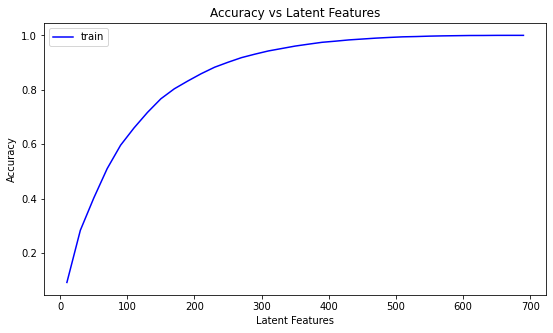

In [23]:
udc3.fn_svd_plot(
    df_user_item=df_user_item,
    lat_start=10,
    lat_stop=710,
    lat_step=20,
    validate=False, #we are not validating by now!
    plot=True,
    verbose=True)

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [29]:
#I could use a better splitting method, but I will not change it!
df_train = df_inter_enc.head(40000)
df_test = df_inter_enc.tail(5993)
print('original dataset: {} rows x {} cols'\
      .format(df_inter_enc.shape[0], 
              df_inter_enc.shape[1]
))
print('splitted in Train (Main): {} rows x {} cols and Test: {} rows x {} cols'\
      .format(df_train.shape[0], 
              df_train.shape[1], 
              df_test.shape[0], 
              df_test.shape[1]
))

original dataset: 45993 rows x 2 cols
splitted in Train (Main): 40000 rows x 2 cols and Test: 5993 rows x 2 cols


Testing subfunction:    

In [35]:
df_user_item_train = udc3.fn_create_user_item_matrix(
                          df=df_train,
                          verbose=False
)
print('{:.0f} user-items in Train (Main): {} rows x {} cols'\
      .format(df_user_item_train.sum().sum(),
              df_user_item_train.shape[0], 
              df_user_item_train.shape[1]
))

29264 user-items in Train (Main): 4487 rows x 714 cols


In [37]:
df_user_item_test = udc3.fn_create_user_item_matrix(
                          df=df_test,
                          verbose=False
)
print('{:.0f} user-items in Test: {} rows x {} cols'\
      .format(df_user_item_test.sum().sum(),
              df_user_item_test.shape[0], 
              df_user_item_test.shape[1]
))

4445 user-items in Test: 682 rows x 574 cols


Creating the main function

In [ ]:
#########1#########2#########3#########4#########5#########6#########7#########8
def fn_create_test_and_train_user_item(df,
                                       train_size,
                                       verbose=False):
    '''This function takes a dataset, splits it in Train and Test and returns
    some useful dataframes and series for analysis.


    Inputs:
      - df (mandatory) - a kind of df_inter_enc Dataframe to be splitted into a 
        Train and a Test Dataframe (Users as rows and Articles as columns) - 
        (Pandas Dataframe)
      - train_size (mandatory) - size (number of rows) for the Train Dataframe
        (Integer)
      - verbose (optional) - if you want some verbosity in your function -
        (Boolean, default=False)
    Outputs:
      - df_user_item_train - a Pandas user-item Dataframe for Train
      - df_user_item_test - a Pandas user-item Dataframe for Test
      - test_id - all of the test User IDs
      - test_art - all of the test Article IDs
    '''
    if verbose:
        print('###function create test and train user-item started')
                
    start_main = time()
    orig_row = df.shape[0]
    orig_col = df.shape[1]

    if verbose:
        print('original dataset: {} x {}'.format(orig_row, orig_col))

    if train_size >= orig_row:
        raise Exception('cannot process, train is as or larger than df')
    else:
        df_train = df.head(train_size)
        df_test = df.tail(orig_row-train_size)
        
    #first step: create my user items Arrays
    df_user_item_train = udc3.fn_create_user_item_matrix(
                          df=df_train,
                          verbose=verbose
    )
    df_user_item_test = udc3.fn_create_user_item_matrix(
                         df=df_test,
                         verbose=verbose
    )
    if verbose:
        print('dataset sizes - train: {} x {}, test: {} x {}'\
              .format(df_train.shape[0], 
                      df_train.shape[1], 
                      df_test.shape[0], 
                      df_test.shape[1]
    ))
    #second step, rows (Users) and columns (Articles) for test dataframe
    sr_test_id = df_user_item_test.index.values
    sr_test_art = df_user_item_test.columns.values

    end = time()

    if verbose:
        print('elapsed time: {:.4f}s'.format(end-start_main))

    return df_user_item_train, df_user_item_test, sr_test_id, sr_test_art

In [148]:
df_user_item_train, df_user_item_test, sr_test_id, sr_test_art =\
udc3.fn_create_test_and_train_user_item(
    df=df_inter_enc, 
    train_size=40000,
    verbose=True
)

###function create test and train user-item started
original dataset: 45993 x 2
###function create user item matrix started
user matrix has 4487 users (rows) and 714 articles (columns)
elapsed time: 1.2371s
###function create user item matrix started
user matrix has 682 users (rows) and 574 articles (columns)
elapsed time: 0.3612s
dataset sizes - train: 40000 x 2, test: 5993 x 2
elapsed time: 1.6033s


In [40]:
df_user_item_test.head(4)

article_id,0,2,4,8,9,12,14,15,16,18,20,25,26,28,29,30,32,33,34,36,39,40,43,48,50,51,53,54,57,58,59,60,62,64,65,68,74,76,77,78,...,1398,1400,1401,1402,1403,1404,1405,1406,1407,1408,1409,1410,1411,1412,1414,1415,1416,1418,1419,1420,1422,1423,1424,1425,1426,1427,1428,1429,1430,1431,1432,1433,1434,1435,1436,1437,1439,1440,1441,1443
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2917,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3024,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3093,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3193,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Index (**rows**) for Users IDs

In [41]:
df_user_item_test.index.values[:4]

array(['2917', '3024', '3093', '3193'], dtype=object)

Columns (**columns**) for Articles IDs

In [42]:
df_user_item_test.columns.values[:4]

array([0, 2, 4, 8])

So, we will start talking about **Users**

- Users in our user_item Array are **rows**

- and rows in Pandas Dataframe are named **index** (and a Pandas Dataframe when it have only **numeric values** is nothing more than a Numpy Array embellished with a good frame for columns and rows names)

- first task, find Users in common, so it will be an **Intersection**

In [43]:
len(np.intersect1d(df_user_item_test.index.values, #Users in common
                   df_user_item_train.index.values,#Users 
                   assume_unique=True))

20

- second task, find Users that are different, and it will be an **Diff 1D**

In [44]:
len(np.setdiff1d(df_user_item_test.index.values, #Users that are different
                 df_user_item_train.index.values,#Users
                 assume_unique=True))

662

Then, about **Articles**

- Articles in our user_item Array are **columns**

- first task, find Articles in common, so it will be an **Intersection**

In [45]:
len(np.intersect1d(df_user_item_test.columns.values, #Articles in common
                   df_user_item_train.columns.values,#Articles
                   assume_unique=True))

574

- second task, find Articles that are different, and it will be an **Diff 1D**

In [46]:
len(np.setdiff1d(df_user_item_test.columns.values, #Articles thar are different
                 df_user_item_train.columns.values,#Articles
                 assume_unique=True))

0

Well, I need to give here a better **explanation**:   

- first, SVD (**not** FunkSVD) only works if you have some kind of "consistence";

- this "consistense" says that when you break an Array int its most **Basic** form, that is one series of **line** Vectors, one kind of **Identity** Array (not properly **Identity**, as it have parameters and not only one, so it is a **diagonal** Array) and finally another series of **column** Vectors, you need to follow some rules;

- and the rule is "there should be no **Null** vector anywhere", so if you have in some place a **User** or **Item** with no parameters, SVD will **not** work!

When we were dealing with our **whole** user-item Array, this "consistence" had a kind of a "magic" garantee:    

- as it came from a **intermediary** Dataframe (or in SQL language, a **Table**) from a Database;

- the only reasont for an item to be in a intermediary Dataframe is to relate one item from one Table, with one item from the other Table, so creating a **n:m** relationship;

- to the "consistence" necessary for SVD was ensured by the **data structure**.

What happens when we break this dataframe in two? There is no more garantee:    

- now, with some **luck**, it will not break;

- sometimes it could break for **User**;

- othertimes it could break for **Items**.

Sorry for all this text, I made it only for organizing my ideas over this project!


In [47]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 

sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many movies can we make predictions for in the test set?': b,
    'How many movies in the test set are we not able to make predictions for because of the cold start problem?': d
} #articles

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [51]:
df_user_item_train.head(4)

article_id,0,2,4,8,9,12,14,15,16,18,20,25,26,28,29,30,32,33,34,36,39,40,43,48,50,51,53,54,57,58,59,60,62,64,65,68,74,76,77,78,...,1402,1403,1404,1405,1406,1407,1408,1409,1410,1411,1412,1414,1415,1416,1418,1419,1420,1421,1422,1423,1424,1425,1426,1427,1428,1429,1430,1431,1432,1433,1434,1435,1436,1437,1439,1440,1441,1442,1443,1444
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [151]:
# Use these cells to see how well you can use the training 
# decomposition to predict on test data
start = time()
u_train, s_train, vt_train =  np.linalg.svd(df_user_item_train)
end = time()
print('elapsed time: {:.4f}s'.format(end-start))

u_train.shape, s_train.shape, vt_train.shape

elapsed time: 5.7909s


((4487, 4487), (714,), (714, 714))

In [152]:
start = time()
u_test, s_test, vt_test =  np.linalg.svd(df_user_item_test)
end = time()
print('elapsed time: {:.4f}s'.format(end-start))

u_test.shape, vt_test.shape

elapsed time: 0.2028s


((682, 682), (574, 574))

In [153]:
sr_train_id = df_user_item_train.index
sr_test_id = df_user_item_test.index

comm_id = list(set(sr_train_id) & set(sr_test_id))
df_user_item_test = df_user_item_test.loc[comm_id]
df_user_item_test.shape[0]

20

In [154]:
df_user_item_test.shape

(20, 574)

Original curve:

In [155]:
df_user_item_train, df_user_item_test, sr_test_id, sr_test_art =\
udc3.fn_create_test_and_train_user_item(
    df=df_inter_enc, 
    train_size=40000,
    verbose=True
)

###function create test and train user-item started
original dataset: 45993 x 2
###function create user item matrix started
user matrix has 4487 users (rows) and 714 articles (columns)
elapsed time: 1.2513s
###function create user item matrix started
user matrix has 682 users (rows) and 574 articles (columns)
elapsed time: 0.4408s
dataset sizes - train: 40000 x 2, test: 5993 x 2
elapsed time: 1.7010s


In [131]:
#########1#########2#########3#########4#########5#########6#########7#########8
def fn_svd_latent(df_user_item,
                  ls_latent_feat,
                  validate=False,
                  df_test=None,
                  verbose=False):
    '''This function iterates latent features for SVD Arrays.

    New version: implemented Train feature. So the function was adapted in a way
    that it will not affect his original behavior. Now it is possible to plot
    graphs for model validation;

    The code here presented is strongly based on the Udacity Jupyter Notebook
    Recommendations wit IBM, and is part of the learning exercise, necessary to
    complete the third project of Data Scientist course. It was conceived as a
    learning guide for students who wants to go deeper in Python/Pandas.

    Inputs:
      - df_user_item (mandatory) - dataframe ind user-item for making the
        copycat model and compare to the original
      - ls_latent_feat (mandatory) - a list of latent features sizes to be 
        simulated (List)
      - validate (optional) - if you will be validating, set it as True -
        (Boolean, default=False) 
      - verbose (optional) - if you want some verbosity in your function -
        (Boolean, default=False)
    Outputs:
      - sum_err - a list of summation errors for each step of the simulation
      - s_new - the intermediary diagonal matrix (for future validation, with
        new data)
    '''
    start = time()

    if verbose:
        print('###function SVD latent started')

    #Making the SVD on the User-Item array
    #decomposing the Array to his basic elements
    #(two Autovectors and one fundamental parameter in a Diagonal Array)
    u, s, vt =  np.linalg.svd(df_user_item)
    sum_err = []

    if validate:
        if verbose:
            print ('*validation behavior started')

        #step zero (preparation)
        sum_test = []
        sr_main_id = df_user_item.index #now user-item will be our Train data
        sr_test_id = df_test.index
        sr_test_art = df_test.columns.values

        comm_id = list(set(sr_main_id) & set(sr_test_id)) #users in common
        comm_col = df_user_item.columns.intersection(sr_test_art)

        main_comm_id = df_user_item.index.isin(sr_test_id)
        main_comm_col = df_user_item.columns.isin(sr_test_art)

        u_test = u[main_comm_id, :]
        vt_test= vt[:, main_comm_col]
        
        for k in ls_latent_feat: #more explanations on normal behavior    
            u_main, s_main, vt_main = u[:, :k], np.diag(s[:k]), vt[:k, :]
            #only two to chop, as Test uses main parameter learned from Train 
            u_val, vt_val = u_test[:, :k], vt_test[:k, :]

            #1.creating model estimates
            df_user_item_main = np.around(np.dot(np.dot(u_main, s_main), 
                                         vt_main))
            df_user_item_val = np.around(np.dot(np.dot(u_val, s_main), 
                                         vt_val))
            
            #2.taking the differences between actual and modellized
            diff_main = np.subtract(df_user_item, 
                                    df_user_item_main)
            diff_val = np.subtract(df_test.loc[comm_id, :],
                                   df_user_item_val) #predicted user_item

            err_main = np.sum(np.sum(np.abs(diff_main)))
            err_val = np.sum(np.sum(np.abs(diff_val)))
            #print('*err {} err test {}'.format(err_main, err_val))
            #take errors for each simulation cicle
            sum_err.append(err_main)
            sum_test.append(err_val)

        end=time()
        if verbose:
            print('time to process: {:.4f}s'.format(end-start))

        return sum_err, sum_test

    else:
        if verbose:
            print ('*normal behavior started')

        for k in ls_latent_feat: #test for diverse parameters
            #restructure, rebuilding with k latent features
            #u[:, :k] <-this guy is an Array and rows will be shortened to k
            #s[:k]<-is a vector (representing a diagonal Array), will be 
            #       chopped in both directions
            #vt[:k, :] <-this one is an Array will be chopped to k lines
            #the idea is to reduce dimensionallity
            #less explanatory equations for the model, trying to NOT map noise
            u_new, s_new, vt_new = u[:, :k], np.diag(s[:k]), vt[:k, :]    
    
            #make the dot product between its components, rebuild user_item
            #a similar Array, following the rules of our reduced model
            df_user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
            #compute the error for each prediction to actual value
            #takes user-item array and subtrat from it the estimated user-item
            #this gives us an idea of the total error that we are impetrating by 
            #using a model, instead of raw data
            diffs = np.subtract(df_user_item, df_user_item_est)
    
            #total errors and keep track of them
            #sum the modules for both dimmensions
            err = np.sum(np.sum(np.abs(diffs)))
            #append them in a list, for plotting the graph (Y-axis)
            sum_err.append(err)

        end=time()
        if verbose:
            print('time to process: {:.4f}s'.format(end-start))

        return sum_err

function `fn_svd_client` created!

In [157]:
#########1#########2#########3#########4#########5#########6#########7#########8
def fn_svd_plot (df_user_item,
                 lat_start=10,
                 lat_stop=710,
                 lat_step=20,
                 validate=False,
                 df_test=None,
                 plot=False,
                 verbose=False):
    '''This function works as a toolkit for plotting/validating SVD Arrays.

    The code here presented is strongly based on the Udacity Jupyter Notebook
    Recommendations wit IBM, and is part of the learning exercise, necessary to
    complete the third project of Data Scientist course. It was conceived as a
    learning guide for students who wants to go deeper in Python/Pandas.

    Inputs:
      - df_user_item (mandatory) - an Array in the shape of User-Item (Pandas
        Dataframe)
      - latent parameters (optional) - defining (start, stop, step) for the
        size of latent features to be measured in each step
        (default: (10,710,20))
        *if you want to simulate starting from less than 10 latent, please 
         alter lat_start parameter
        *if you want a shorter/longer, alter lat_stop
        *if you need more or less graining, ater lat_step
      - validate (optional) - if you are doing a validation, please, inform
        the second dataframe (df_test) - (default=False)
      - plot (optional) - if you want to plot the graph (default=False)
      - verbose (optional) - if you want some verbosity in your function -
        (Boolean, default=False)
    Output:
      - a plotted graphic with the results
    '''
    start = time()

    if verbose:
        print('###function SVD plot toolkit started')

    #step zero - preparation    
    #for simulating different choices on latent features
    ls_latent_feat = np.arange(lat_start,
                               lat_stop,
                               lat_step) #start, stop, step (X-axis)
    if validate:
        sum_err, sum_test = fn_svd_latent(
                                df_user_item,
                                ls_latent_feat=ls_latent_feat,
                                validate=True,
                                df_test=df_test,
                                verbose=verbose
    )
    else:    
        sum_err = fn_svd_latent(
                      df_user_item,
                      ls_latent_feat=ls_latent_feat,
                      validate=False,
                      verbose=verbose
    )
    if plot:
        #determination of the normalization factior for only one curve
        item_num = df_user_item.sum().sum() #get the number of valid items
      
        if validate:
            #determination of the normalization factor for both curves
            item_num_add = df_test.sum().sum() #complete the number of valids
            tot_item = item_num + item_num_add #new valid items total
            tot_row = df_user_item.shape[0] + df_test.shape[0] #total users
            item_num = df_user_item.shape[0] * (tot_item/tot_row)
            item_num_test = df_test.shape[0] * (tot_item/tot_row)
        
        sim_val = 1 - np.array(sum_err) / item_num #simulated values

        if verbose:
            print('*plotting for {:.0f} items'.format(item_num))

        fig, ax = plt.subplots(figsize=(9, 5))
        ax.plot(ls_latent_feat, 
                sim_val, 
                color='blue', 
                label='train')

        if validate:
            if verbose:
                print('plotting test for {:.0f} items'.format(item_num_test))

            sim_val2 = 1 - np.array(sum_test) / item_num_test
            ax.plot(ls_latent_feat, 
                    sim_val2, 
                    color='red',
                    label='test')
            ax.vlines(x=245, 
                      ymin=0, 
                      ymax=1, 
                      colors='green', 
                      linestyles='dashed', 
                      label='best fitting')

        ax.legend(loc='best')
        ax.set_xlabel('Latent Features')
        ax.set_ylabel('Accuracy')
        ax.set_title('Accuracy vs Latent Features');
 
    end=time()
    print('time to process: {:.4f}s'.format(end-start))

    return True

function `fn_svd_plot` created!

###function SVD plot toolkit started
###function SVD latent started
*validation behavior started
time to process: 13.2823s
*plotting for 29261 items
plotting test for 4448 items
time to process: 13.3495s


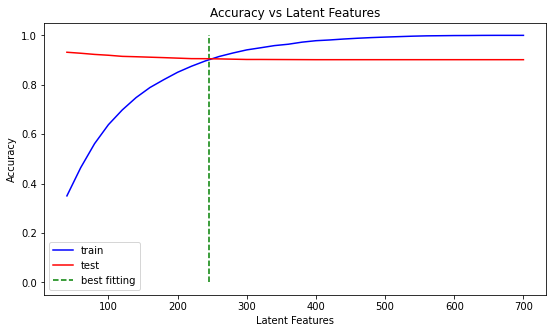

In [158]:
plot=fn_svd_plot(
    df_user_item=df_user_item_train,
    lat_start=40,
    lat_stop=720,
    lat_step=20,
    validate=True,
    df_test=df_user_item_test,
    plot=True,
    verbose=True
)

In [20]:
!cp /content/gdrive/MyDrive/GoogleColab/DataScientistStudies3/udacourse3.py .
#reloader for our functions library
from importlib import reload 
import udacourse3 as udc3

udc3 = reload(udc3)

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

Features decrease their **explanatory power**, as you add more and more of them.

The mechanics are quite simple. In this case have two sets of data, taken by alleatory from the **same** mother dataset. It could be quite different. For example, I want to create a **mathematical model** for explaining some kind of phenomenam, that is quite complex.

When we don't have any equation, the explanatory power of my whole model is **zero**. That means that I am completely blind. When I add my first equation, things start to change a bit.

My first equation adds a lot of explanatory power, whithout adding too much noise. So, from **0.5** Accuracy (only by chance I can correctly explain **50%** of a binary phenomenon), and with only one my **first** equation, I jump to near to **90%** of explanatory power.

Adding the second equation, I increase the complexity of my mathematical model, and also the explanatory power of my model. And so on. And in some cases, with only like 5-10 equations, I reach the best explanatory power of my **whole model**. So, adding more equations, I am only fitting more **noise** from my training dataset.

This can be seen when my model fits so well with my **train** data, but when I try to use it with my **test** data, things don't go so well! This phenomenon is named **overfitting**.

If I am using SVD to map other **physical** phenomena, like the movement of particles, normally I don't go so far and the best thing to do normally is to stop at the 5th... 10th equation! In this case, if I want a better explanatory power, I will need to collect more data (or get data in a more accurate way), or start trying other **nonlinear** approaches.

In our case, noise is **not a so terrible** problem. I want to go further and try to recommend so many articles as I can do in this way. So, I can go further and try to recommend, I don't know... using **150-240** explanatory equations? (in other words, 150-240 **latent features**)

After 240 explanatory equations, I can see an evident problem of overfitting. And what I am adding, after that, are equations that are only trying to "model" noise!

<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendations with IBM project! 

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the [rubric](https://review.udacity.com/#!/rubrics/2322/view). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

In [ ]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])